# Blueberry yield modelling

This notebook contains the scripts to:

1. Create a plot to compare yield in our database to yield in the literature


To reproduce the results of this notebook, you will need to install a conda environment containing the packages listed in `requirements.txt`. Because **`weathercan`** and **`rstanarm`** are not available from conda, these packages must be installed manually.

In [1]:
nonconda_packages <- c("weathercan", "rstanarm")
packages_to_install <- nonconda_packages[!(nonconda_packages %in% installed.packages()[,"Package"])]
if(length(packages_to_install)) install.packages(packages_to_install)

In [2]:
Sys.setlocale("LC_ALL","English")
library("tidyverse")

[1] "LC_COLLATE=English_United States.1252;LC_CTYPE=English_United States.1252;LC_MONETARY=English_United States.1252;LC_NUMERIC=C;LC_TIME=English_United States.1252"

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.0     v purrr   0.3.4
v tibble  3.0.0     v dplyr   0.8.5
v tidyr   1.0.3     v stringr 1.4.0
v readr   1.3.1     v forcats 0.5.0

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



## Literature yields

How does yields obtained in our data set compare to the literature?

Parsed with column specification:
cols(
  Author = col_character(),
  Min = col_double(),
  Max = col_double()
)



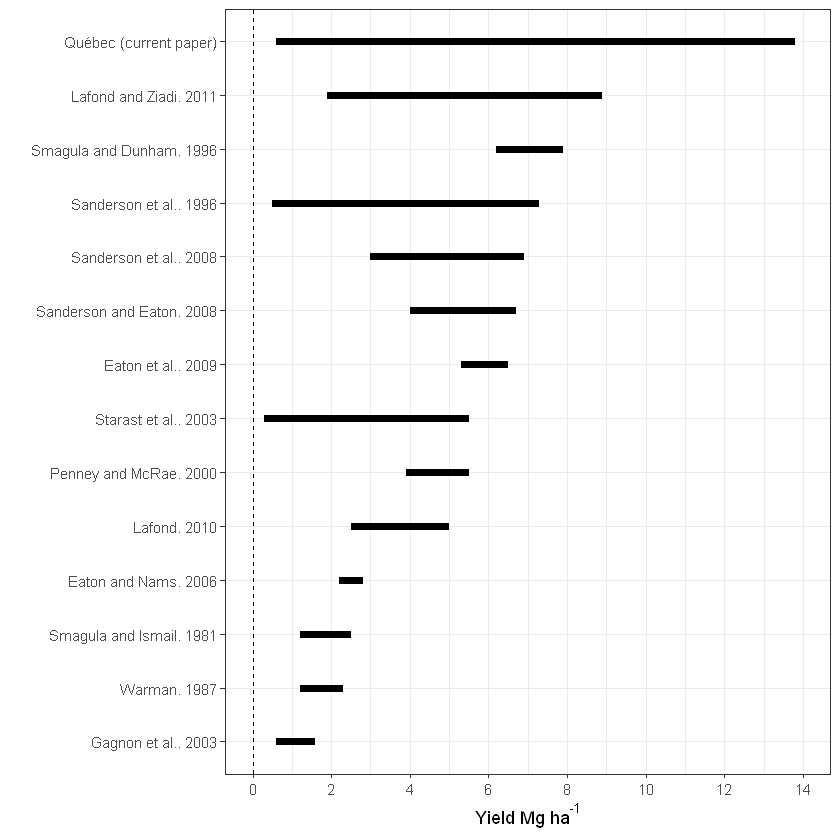

In [3]:
litterature_yields <- read_csv("data/literature-yield.csv")

litterature_yields %>%
  mutate(Author = fct_reorder(Author, Max)) %>%
  ggplot(aes(x = Min, y = Author)) +
  geom_segment(aes(xend = Max, yend = Author), lwd = 2) +
  scale_x_continuous(limits = c(0, 14), breaks = seq(from = 0, to = 15, by = 2)) +
  geom_vline(xintercept = 0, linetype = 2) +
  labs(x = expression("Yield Mg ha"^"-1"), y = "") +
  theme_bw() +
  ggsave("images/litterature-yields.png", height = 3, width = 6, dpi = 300)

## Blueberry data

Data are stored in a single data set.

In [4]:
library("lubridate")
library("tidymodels")
library("skimr")
df_source <- read_csv("data/data.csv", na = c("", "."))
skim(df_source)


Attaching package: 'lubridate'


The following objects are masked from 'package:dplyr':

    intersect, setdiff, union


The following objects are masked from 'package:base':

    date, intersect, setdiff, union


-- Attaching packages -------------------------------------- tidymodels 0.1.0 --

v broom     0.5.6      v rsample   0.0.6 
v dials     0.0.6      v tune      0.1.0 
v infer     0.5.1      v workflows 0.1.1 
v parsnip   0.1.1      v yardstick 0.0.6 
v recipes   0.1.12     

-- Conflicts ----------------------------------------- tidymodels_conflicts() --
x scales::discard() masks purrr::discard()
x dplyr::filter()   masks stats::filter()
x recipes::fixed()  masks stringr::fixed()
x dplyr::lag()      masks stats::lag()
x dials::margin()   masks ggplot2::margin()
x yardstick::spec() masks readr::spec()
x recipes::step()   masks stats::step()

Parsed with column specification:
cols(
  .default = col_double(),
  Project = col_character(),
  Site = col_character(),
  Coordinates =

-- Data Summary ------------------------
                           Values   
Name                       df_source
Number of rows             1504     
Number of columns          30       
_______________________             
Column type frequency:              
  character                3        
  numeric                  27       
________________________            
Group variables            None     

-- Variable type: character ----------------------------------------------------
# A tibble: 3 x 8
  skim_variable n_missing complete_rate   min   max empty n_unique whitespace
* <chr>             <int>         <dbl> <int> <int> <int>    <int>      <int>
1 Project               0             1     2     6     0       19          0
2 Site                  0             1     7    16     0        6          0
3 Coordinates           0             1    17    17     0        6          0

-- Variable type: numeric ------------------------------------------------------
# A tibble: 27 x 

There are a lot of missing data in the Mo leaf content and the berry dry matter fraction. But oligo-elements are important information. We will proceed to missing data imputation further on. 

Dosage is put on element scale.

In [5]:
df_source <- df_source %>%
  mutate(
    id = 1:nrow(.),
    `P dose (kg/ha)` = `P2O5 dose (kg/ha)` / 2.29,
    `K dose (kg/ha)` = `K2O dose (kg/ha)` / 1.2
  )

## Weather

Weather indices are genereted from data fetched from Environment Canada with the **`weathercan`** package. The **`sp`** package is needed as dependency of **`weathercan`** to look for the closest stations.

In [6]:
library("weathercan")
library("sp")


Attaching package: 'weathercan'


The following object is masked from 'package:dials':

    stations




Coordinates are stored by site in `sites.csv`.

In [7]:
sites <- read_csv("data/sites.csv")
df_source <-
  df_source %>%
  left_join(sites, by = "Site")

Parsed with column specification:
cols(
  Site = col_character(),
  Latitude = col_double(),
  Longitude = col_double()
)



### Select weather stations

We have the following Year/Site combinaisons.

In [8]:
year_site <- df_source %>%
  distinct(Year, Site, Latitude, Longitude)

We look for the closest stations with data starting 6 years before observations. To make this number dynamic, we set it as a variable `nyears_before`.

In [9]:
nyears_before <- 6
blueberry_stations <- list()
for (i in 1:nrow(year_site)) {
  blueberry_stations[[i]] <- stations_search(
    coords = c(year_site$Latitude[i], year_site$Longitude[i]),
    starts_latest = year_site$Year[i] - nyears_before - 2,
    ends_earliest = year_site$Year[i] + 3,
    dist = 50, interval = "day"
  )
}

We selected the closest stations.

In [10]:
year_site$station_id <- NA
year_site$station_name <- NA
for (i in seq_along(blueberry_stations)) {
  year_site$station_id[i] <- blueberry_stations[[i]]$station_id[1]
  year_site$station_name[i] <- blueberry_stations[[i]]$station_name[1]
}
year_site

Year,Site,Latitude,Longitude,station_id,station_name
<dbl>,<chr>,<dbl>,<dbl>,<int>,<chr>
2001,Normandin,48.98333,-72.53333,5909,HEMON
2001,St-Eugène,48.98333,-72.28333,5909,HEMON
2001,St-Léon,48.66667,-71.53333,5939,ST LEON DE LABRECQUE
2003,Normandin,48.98333,-72.53333,10872,NORMANDIN
2003,St-Eugène,48.98333,-72.28333,10872,NORMANDIN
2003,St-Léon,48.66667,-71.53333,10797,MISTOOK
2005,Albanel,48.88333,-72.45000,10872,NORMANDIN
2004,St-Eugène,48.98333,-72.28333,10872,NORMANDIN
2005,St-Eugène,48.98333,-72.28333,10872,NORMANDIN


Station `ST LEON DE LABRECQUE` seems to generate errors. The next closest one available in 2001 is `ST AMBROISE`.

In [11]:
blueberry_stations[[3]]$station_name

[1] "ST LEON DE LABRECQUE" "ST AMBROISE"          "FALARDEAU"           
[4] "LAC STE CROIX"        "PERIBONCA"            "JONQUIERE"

In [12]:
year_site$station_id[3] <- blueberry_stations[[3]]$station_id[2]
year_site$station_name[3] <- blueberry_stations[[3]]$station_name[2]

We will fetch weather by year and station ID.

In [13]:
year_station <- year_site %>% distinct(Year, station_id)

### Fetch weather

We suppose that seasons start on April 1st and end at mid-August. The first loop stores the weather of the year of the experiment. This will be used to asses feature importance.

#### Weather current

These data are the one that occured during the year of the experiment.

We unnest the list of lists, the old fashion way.

In [14]:
load("output/weather_current.RData")

#### Weather before

Now for each station, we fetch weather data 6 years before the experiment. These data will be used for prediction. Cells that fetch weather are deactivated since data have already been fetched and saved in a RData file.

We unnest the list of lists.

In [15]:
load("output/weather_before.RData")

#### Weather 2016 (for discussion)

There is a discussion in the paper about year 2016.

In [16]:
load("output/weather_2016.RData")

### Compute weather indices

#### Weather current

For each month, we compute total **precipitation** and **mean temperature**. 

In [17]:
temp_prec_current <- weather_current %>%
  group_by(station_id, year, month) %>%
  summarise(
    total_precip = sum(total_precip, na.rm = TRUE),
    mean_temp = mean(mean_temp, na.rm = TRUE)
  ) %>%
  pivot_wider(names_from = month, values_from = c(total_precip, mean_temp))

We compute the number of days per month were air temerature falls **under 0 degrees**.

In [18]:
frozen_current <- weather_current %>%
  group_by(station_id, year, month) %>%
  summarise(frozen = sum(mean_temp < 0, na.rm = TRUE)) %>% 
  pivot_wider(names_from = month, values_from = frozen)
names(frozen_current)[-c(1, 2)] <- paste0("frozen_", names(frozen_current)[-c(1, 2)])

While the number of freezing days can affect flowering, the number of days with mean temperature > 26 °C can affect pollination.

In [19]:
toowarm_current <- weather_current %>%
  group_by(station_id, year, month) %>%
  summarise(toowarm = sum(mean_temp >= 26, na.rm = TRUE)) %>% 
  pivot_wider(names_from = month, values_from = toowarm)
names(toowarm_current)[-c(1, 2)] <- paste0("toowarm_", names(toowarm_current)[-c(1, 2)])

Lastly, the degree days are computed between May (julilan day `r yday("2000-05-01")`) and mid-August (julilan day `r yday("2000-08-15")`).

In [20]:
GDD_current <- weather_current %>%
  mutate(julian_day = yday(date)) %>% 
  filter(
    julian_day >= yday("2000-05-01"),
    julian_day <= yday("2000-08-15")
  ) %>%
  group_by(year, station_id) %>% 
  summarise(GDD = sum(mean_temp >= 5, na.rm = TRUE))

All indices in the same table.

In [21]:
weather_indices_current <- temp_prec_current %>%
  left_join(frozen_current, by = c("station_id", "year")) %>% 
  left_join(toowarm_current, by = c("station_id", "year")) %>% 
  left_join(GDD_current, by = c("station_id", "year")) %>%
  ungroup() %>% 
  mutate(year = as.numeric(year)) %>% 
  rename(Year = year)
names(weather_indices_current)[-c(1, 2)] <- paste0("weather_current.", 
                                                   names(weather_indices_current)[-c(1, 2)])

#### Weather summary

The table must be organized...

In [22]:
weather_indices_current_tidy <- weather_indices_current %>%
  pivot_longer(cols = -c(station_id, Year)) %>%
  mutate(category = case_when(
    str_detect(name, "precip") ~ "Total precipitations (mm)",
    str_detect(name, "temp") ~ "Mean temperature (°C)",
    str_detect(name, "frozen") ~ "Number of freezing days"
  ),
        time = case_when(
    str_detect(name, "04") ~ "04",
    str_detect(name, "05") ~ "05",
    str_detect(name, "06") ~ "06",
    str_detect(name, "07") ~ "07",
    str_detect(name, "08") ~ "08",
  ),
         time = ymd(paste0(Year, "-", time), truncated = 1)
  )

... to be plotted.

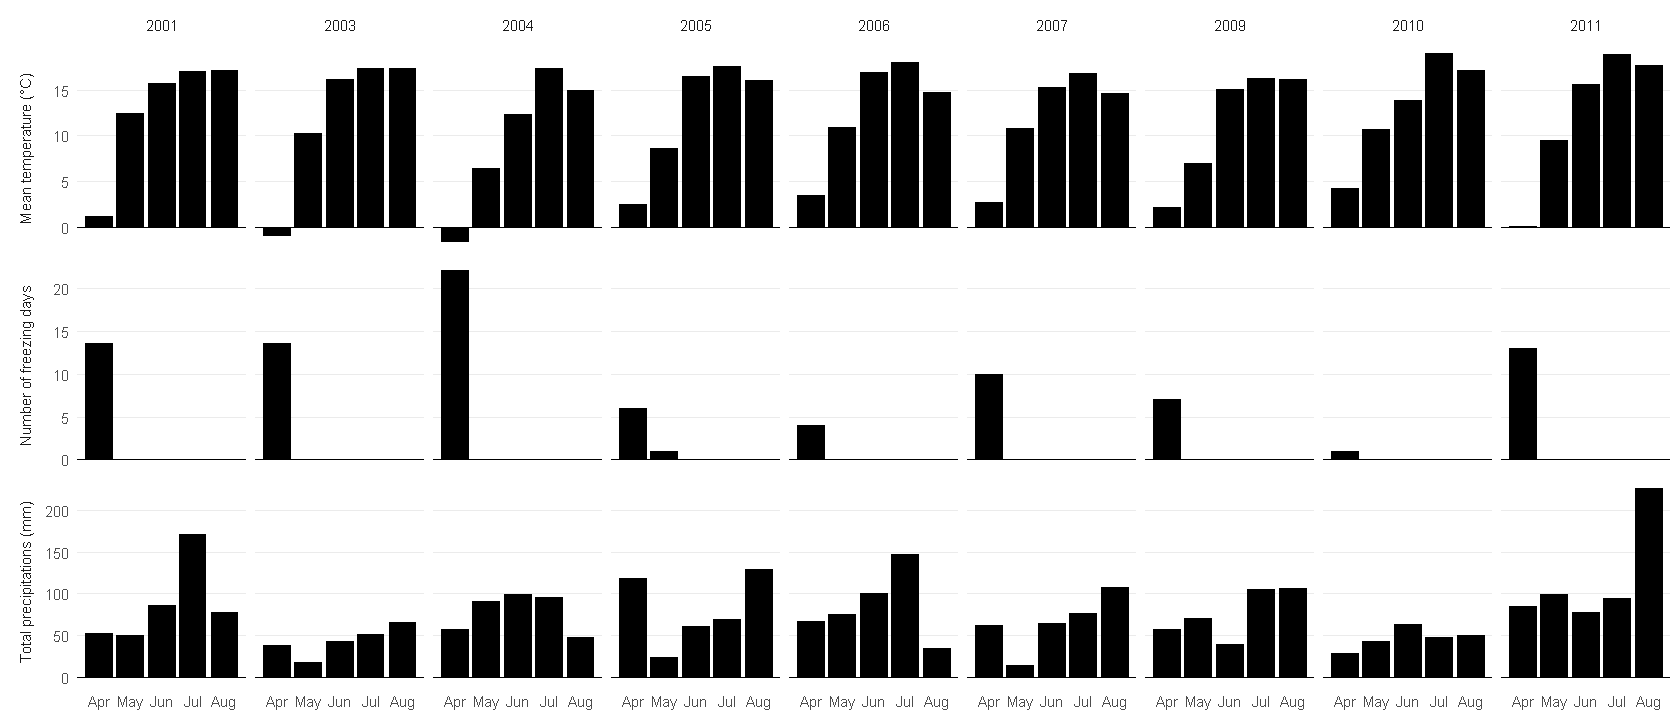

In [23]:
options(repr.plot.height = 6, repr.plot.width = 14)
weather_indices_current_tidy %>%
  group_by(category, year = year(time), month = month(time)) %>%
  summarize(value = mean(value), time = mean(time)) %>%
  drop_na() %>%
  ggplot(aes(x = time, y = value)) +
  facet_grid(category ~ year, scales = "free", switch="y") +
  expand_limits(y = 0) +
  geom_col(fill = "black") +
  geom_hline(yintercept = 0) +
  theme_minimal() +
  theme(panel.grid.minor.y = element_blank(),
        panel.grid.minor.x = element_blank(),
        panel.grid.major.x = element_blank(),
        strip.placement = "outside",
        axis.title.x = element_blank(),
        axis.title.y = element_blank(),
        strip.background = element_rect(fill = "transparent", colour = "transparent")) +
  ggsave("images/weather-statistics.png", height = 6, width = 14, dpi = 120)

#### Weather, 6 years before

For each month, we compute total precipitation and mean temperature 6 years (`nyears_before`) before the growing season. 

In [24]:
temp_prec_before <- list()

# Each element of the list corresponds to a row in year_station
for (i in 1:nrow(year_station)) {
  temp_prec_before[[i]] <-
    weather_before %>%
    # filter to keep the station ID and the 6 years preceeding the 
    # year of the experiment
    filter(
      station_id == year_station$station_id[i],
      year %in% (year_station$Year[i] - nyears_before):(year_station$Year[i] - 1)
    ) %>%
    # Group by year and month...
    group_by(year, month) %>%
    # to compute indices for each month of the 6 preceeeding years
    summarise(
      total_precip = sum(total_precip, na.rm = TRUE),
      mean_temp = mean(mean_temp, na.rm = TRUE)
    ) %>%
    # then regroup by month, excluding the year
    group_by(month) %>%
    # to summarise mean indices per month
    summarise(
      total_precip = mean(total_precip, na.rm = TRUE),
      mean_temp = mean(mean_temp, na.rm = TRUE)
    ) %>%
    # and pivot to a single row corresponding to the year_station table
    pivot_wider(names_from = month, values_from = c(total_precip, mean_temp))
}

# merge all rows together
temp_prec_before <- do.call(rbind, temp_prec_before)

We compute the number of days per month where air temerature falls under 0 degrees, a condition altering flowers.

In [25]:
frozen_before <- list()
for (i in 1:nrow(year_station)) {
  frozen_before[[i]] <- weather_before %>%
    filter(
      station_id == year_station$station_id[i],
      year %in% (year_station$Year[i] - nyears_before):(year_station$Year[i] - 1),
    ) %>%
    group_by(year, month) %>%
    summarise(frozen = sum(mean_temp <= 0, na.rm = TRUE)) %>%
    group_by(month) %>%
    summarise(frozen = mean(frozen)) %>%
    pivot_wider(names_from = month, values_from = frozen)
}
frozen_before <- do.call(rbind, frozen_before)
names(frozen_before) <- paste0("frozen_", names(frozen_before))

The number of days with mean temperature > 26 °C:

In [26]:
toowarm_before <- list()
for (i in 1:nrow(year_station)) {
  toowarm_before[[i]] <- weather_before %>%
    filter(
      station_id == year_station$station_id[i],
      year %in% (year_station$Year[i] - nyears_before):(year_station$Year[i] - 1),
    ) %>%
    group_by(year, month) %>%
    summarise(toowarm = sum(mean_temp <= 26, na.rm = TRUE)) %>%
    group_by(month) %>%
    summarise(toowarm = mean(toowarm)) %>%
    pivot_wider(names_from = month, values_from = toowarm)
}
toowarm_before <- do.call(rbind, toowarm_before)
names(toowarm_before) <- paste0("toowarm_", names(toowarm_before))

And GDD.

In [27]:
GDD_before <- c()
for (i in 1:nrow(year_station)) {
  GDD_before[i] <-
    weather_before %>%
    filter(
      station_id == year_station$station_id[i],
      year %in% (year_station$Year[i] - nyears_before):(year_station$Year[i] - 1),
    ) %>%
    mutate(julian_day = yday(date)) %>% 
    filter(
      julian_day >= yday("2000-05-01"),
      julian_day <= yday("2000-08-15")
    ) %>% 
    group_by(year) %>%
    summarise(GDD = sum(mean_temp >= 5, na.rm = TRUE)) %>% 
    summarise(GDD_before = mean(GDD)) %>% 
    pull()
}

All indices in the same table.

In [28]:
weather_indices_before <- year_station %>% 
  bind_cols(temp_prec_before) %>%
  bind_cols(frozen_before) %>% 
  bind_cols(toowarm_before) %>% 
  mutate(GDD_before = GDD_before)
names(weather_indices_before)[-c(1, 2)] <- paste0("weather_before.", 
                                                  names(weather_indices_before)[-c(1, 2)])


#### Weather, all years
For the current year and the preceeding year, compute seasonnal weather indices.

In [29]:
weather_all <- bind_rows(weather_current, weather_before) %>%
  distinct()

Compute the indices for each row of the `year_station` table.

In [30]:
temp_prec_currseason <- weather_all %>%
  filter(paste(year, station_id) %in%
         paste(year_station$Year, year_station$station_id)) %>%
  group_by(station_id, year) %>%
  summarise(
    weather_2years.total_precip_curr = sum(total_precip, na.rm = TRUE),
    weather_2years.mean_temp_curr = mean(mean_temp, na.rm = TRUE)
  ) %>%
  ungroup()

And the number of freezing days.

In [31]:
frozen_currseason <- rep(0, nrow(year_station))
for (i in 1:nrow(year_station)) {
  frozen_currseason[i] <- weather_all %>%
    filter(
      station_id == year_station$station_id[i],
      year == year_station$Year[i]
    ) %>%
    group_by(year) %>%
    summarise(frozen = sum(mean_temp <= 0, na.rm = TRUE)) %>%
    pull()
}

We compute the seasonnal indicies the same way, but for the previous year.

In [32]:
temp_prec_prevseason <- weather_all %>%
  filter(paste(year, station_id) %in%
         paste(year_station$Year-1, year_station$station_id)) %>% # minus one here
  group_by(station_id, year) %>%
  summarise(
    weather_2years.total_precip_prev = sum(total_precip, na.rm = TRUE),
    weather_2years.mean_temp_prev = mean(mean_temp, na.rm = TRUE)
  ) %>%
  ungroup()

And the number of freezing days.

In [33]:
frozen_prevseason <- rep(0, nrow(year_station))
for (i in 1:nrow(year_station)) {
  frozen_prevseason[i] <- weather_all %>%
    filter(
      station_id == year_station$station_id[i],
      year == year_station$Year[i] - 1
    ) %>%
    group_by(year) %>%
    summarise(frozen = sum(mean_temp <= 0, na.rm = TRUE)) %>%
    pull()
}

We merge them together, in a similar manner than the previous `weather_indices_*` tables.

In [34]:
weather_indices_2years <- bind_cols(
  year_station,
  temp_prec_currseason %>%
    select(weather_2years.total_precip_curr, weather_2years.mean_temp_curr),
  temp_prec_prevseason %>%
    select(weather_2years.total_precip_prev, weather_2years.mean_temp_prev)
) %>%
  mutate(weather_2years.frozen_curr = frozen_currseason,
         weather_2years.frozen_prev = frozen_prevseason)

### Merge everything

In [35]:
year_station_ <- year_station %>% 
  left_join(weather_indices_current, by = c("Year", "station_id")) %>% 
  left_join(weather_indices_before, by = c("Year", "station_id")) %>%
  left_join(weather_indices_2years, by = c("Year", "station_id"))

year_site_ <- year_site %>% 
  left_join(year_station_, by = c("Year", "station_id")) %>% 
  select(-Latitude, -Longitude)

df_weather <- df_source %>%
  left_join(year_site_, by = c("Year", "Site"))

## Compositional preprocess

### Look up missing values

In leaves,

Loading required package: colorspace

Loading required package: grid

Registered S3 methods overwritten by 'car':
  method                          from
  influence.merMod                lme4
  cooks.distance.influence.merMod lme4
  dfbeta.influence.merMod         lme4
  dfbetas.influence.merMod        lme4

VIM is ready to use.


Suggestions and bug-reports can be submitted at: https://github.com/statistikat/VIM/issues


Attaching package: 'VIM'


The following object is masked from 'package:recipes':

    prepare


The following object is masked from 'package:datasets':

    sleep





 Variables sorted by number of missings: 
      Variable        Count
 Leaf Mo (ppm) 0.5166223404
 Leaf Mn (ppm) 0.3557180851
 Leaf Zn (ppm) 0.3530585106
 Leaf Fe (ppm) 0.3523936170
 Leaf Cu (ppm) 0.3470744681
 Leaf Al (ppm) 0.1808510638
  Leaf B (ppm) 0.1801861702
    Leaf N (%) 0.0033244681
    Leaf P (%) 0.0033244681
    Leaf K (%) 0.0013297872
   Leaf Ca (%) 0.0006648936
   Leaf Mg (%) 0.0006648936


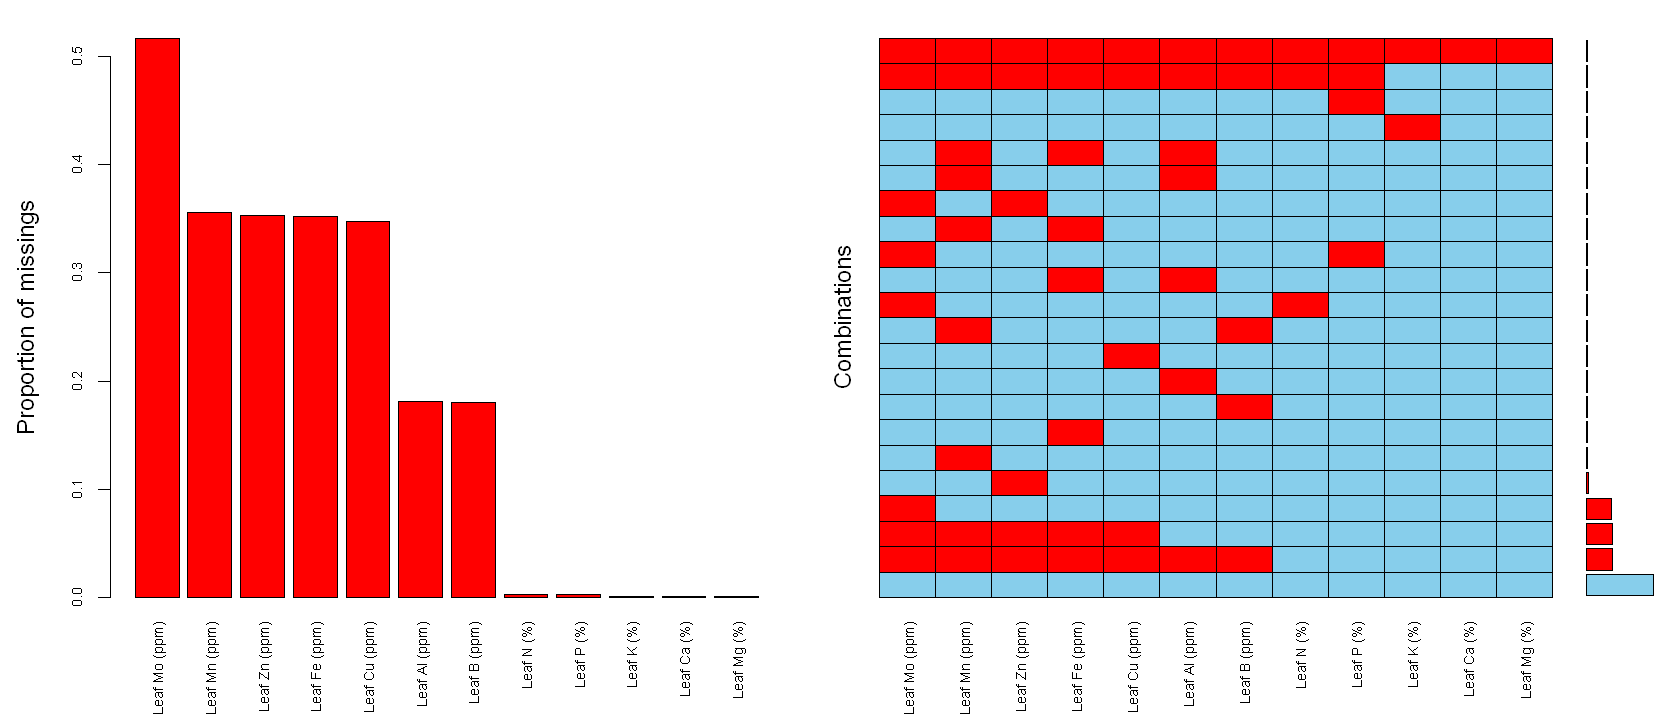

In [36]:
library("VIM")
comp_leaf <- df_source %>%
  select(starts_with("Leaf"))

aggr(comp_leaf, sortVar = TRUE, cex.axis = 0.7)

The proportion of NAs in the Mo (\~55%), Mn, Zn and Fe (\~35%) columns are too high to parse them through imputations. Although Al and B also have pretty high propostions of NAs (~18%), they are important components. They will be kept and imputed.

In soil,


 Variables sorted by number of missings: 
        Variable        Count
  Soil NO3 (ppm) 0.5146276596
  Soil NH4 (ppm) 0.5146276596
  Soil K (mg/kg) 0.0053191489
  Soil P (mg/kg) 0.0006648936
 Soil Ca (mg/kg) 0.0006648936
 Soil Mg (mg/kg) 0.0000000000


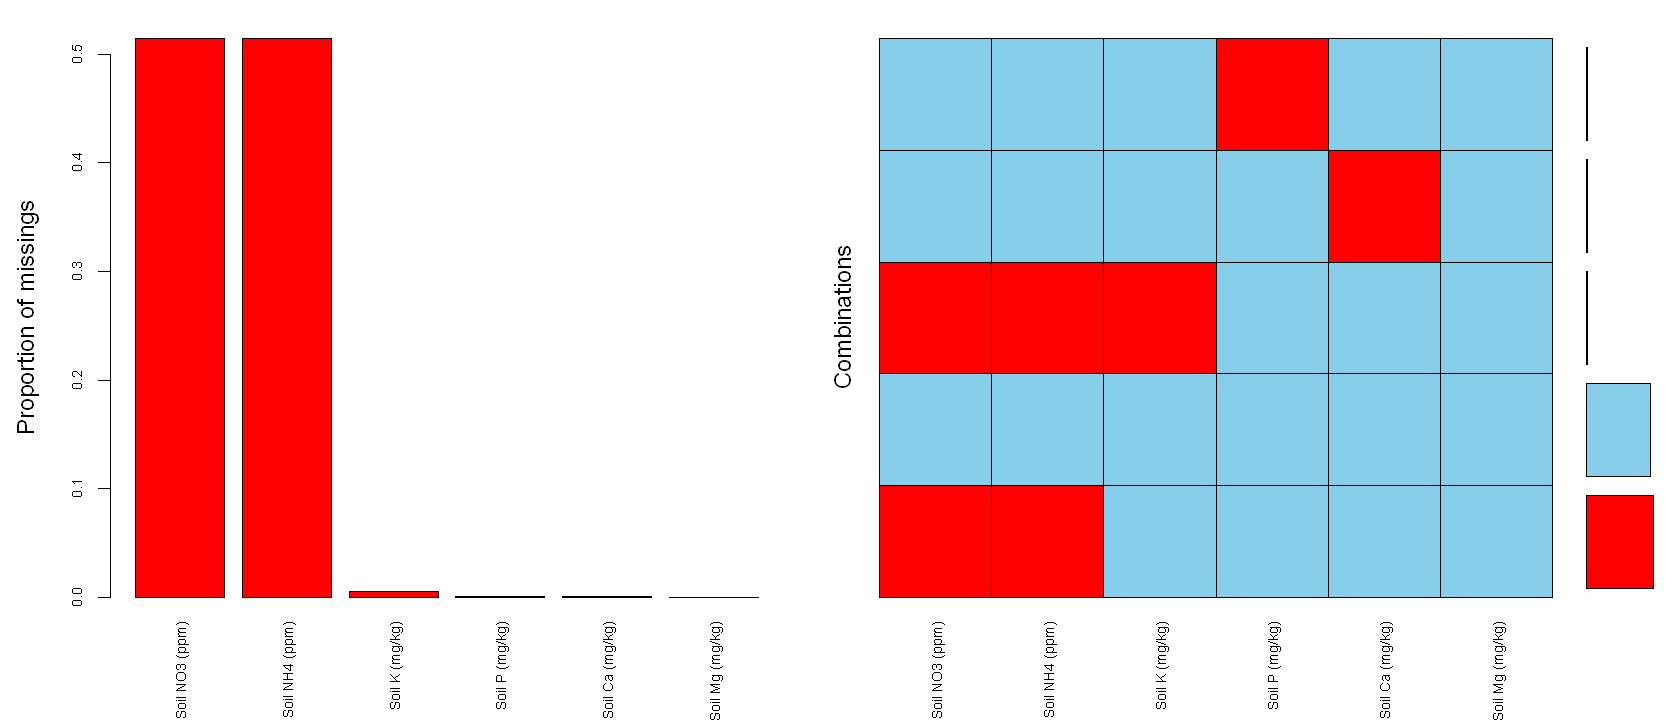

In [37]:
comp_soil <- df_source %>%
  select(starts_with("Soil"))

aggr(comp_soil, sortVar = TRUE, cex.axis = 0.7)

Nitrogen forms have been measured in less than 50%  of the obervations. Unfortunalty, we must rule them out of the analysis. K, P, Ca and Mg are kept.

### Imputations

The imputation is done with a random forest algorithm using the **`mice`** package. Leaves first.

In [38]:
library("mice")

comp_leaf_enough <- comp_leaf %>% 
  select(-`Leaf Mo (ppm)`, -`Leaf Mn (ppm)`, -`Leaf Zn (ppm)`, -`Leaf Cu (ppm)`, -`Leaf Fe (ppm)`)

leaf_comp_names <- names(comp_leaf_enough)
names(comp_leaf_enough) <- c("N", "P", "K", "Ca", "Mg", "Al", "B")

leaf_too_many_nas <- df_source %>% 
  select(id) %>% 
  filter(apply(comp_leaf_enough, 1, function(x) sum(is.na(x)) > 3)) %>% 
  pull()

leaf_imp <- comp_leaf_enough %>% 
  filter(!(df_source$id %in% leaf_too_many_nas)) %>%
  mice(., method = "rf") %>% 
  complete(.)

names(leaf_imp) <- leaf_comp_names


Attaching package: 'mice'


The following objects are masked from 'package:base':

    cbind, rbind





 iter imp variable
  1   1  N  P  K  Al  B
  1   2  N  P  K  Al  B
  1   3  N  P  K  Al  B
  1   4  N  P  K  Al  B
  1   5  N  P  K  Al  B
  2   1  N  P  K  Al  B
  2   2  N  P  K  Al  B
  2   3  N  P  K  Al  B
  2   4  N  P  K  Al  B
  2   5  N  P  K  Al  B
  3   1  N  P  K  Al  B
  3   2  N  P  K  Al  B
  3   3  N  P  K  Al  B
  3   4  N  P  K  Al  B
  3   5  N  P  K  Al  B
  4   1  N  P  K  Al  B
  4   2  N  P  K  Al  B
  4   3  N  P  K  Al  B
  4   4  N  P  K  Al  B
  4   5  N  P  K  Al  B
  5   1  N  P  K  Al  B
  5   2  N  P  K  Al  B
  5   3  N  P  K  Al  B
  5   4  N  P  K  Al  B
  5   5  N  P  K  Al  B


Then soil.

In [39]:
comp_soil_enough <- comp_soil %>% 
  select(-`Soil NO3 (ppm)`, -`Soil NH4 (ppm)`)

soil_comp_names <- names(comp_soil_enough)
names(comp_soil_enough) <- c("P", "K", "Ca", "Mg")

soil_too_many_nas <- df_source %>% 
  select(id) %>% 
  filter(apply(comp_soil_enough, 1, function(x) sum(is.na(x)) > 3)) %>% 
  pull()

soil_imp <- comp_soil_enough %>% 
  filter(!(df_source$id %in% soil_too_many_nas)) %>%
  mice(., method = "rf") %>% 
  complete(.)

names(soil_imp) <- soil_comp_names


 iter imp variable
  1   1  P  K  Ca
  1   2  P  K  Ca
  1   3  P  K  Ca
  1   4  P  K  Ca
  1   5  P  K  Ca
  2   1  P  K  Ca
  2   2  P  K  Ca
  2   3  P  K  Ca
  2   4  P  K  Ca
  2   5  P  K  Ca
  3   1  P  K  Ca
  3   2  P  K  Ca
  3   3  P  K  Ca
  3   4  P  K  Ca
  3   5  P  K  Ca
  4   1  P  K  Ca
  4   2  P  K  Ca
  4   3  P  K  Ca
  4   4  P  K  Ca
  4   5  P  K  Ca
  5   1  P  K  Ca
  5   2  P  K  Ca
  5   3  P  K  Ca
  5   4  P  K  Ca
  5   5  P  K  Ca


### Compute balances

Load SBPs.

In [40]:
library("compositions")
sbp_soil <- read_csv("data/sbp-soil.csv")
sbp_leaf <- read_csv("data/sbp-leaf.csv")

Loading required package: tensorA


Attaching package: 'tensorA'


The following object is masked from 'package:base':

    norm


Loading required package: robustbase

Loading required package: bayesm

Welcome to compositions, a package for compositional data analysis.
Find an intro with "? compositions"



Attaching package: 'compositions'


The following objects are masked from 'package:stats':

    cor, cov, dist, var


The following objects are masked from 'package:base':

    %*%, scale, scale.default


Parsed with column specification:
cols(
  P = col_double(),
  K = col_double(),
  Ca = col_double(),
  Mg = col_double(),
  Fv = col_double()
)

Parsed with column specification:
cols(
  N = col_double(),
  P = col_double(),
  K = col_double(),
  Ca = col_double(),
  Mg = col_double(),
  Al = col_double(),
  B = col_double(),
  Fv = col_double()
)



I have created a small snippet to generate balance definitions from SBPs.

In [41]:
source("lib/ilrDefinition.R")
soil_bal_def <- ilrDefinition(sbp_soil,
                              side = "-+", sep.elem = "",
                              sep.bal = ".", sep.left = "", sep.right = ""
)
leaf_bal_def <- ilrDefinition(sbp_leaf,
                              side = "-+", sep.elem = "",
                              sep.bal = ".", sep.left = "", sep.right = ""
)

Generate leaf balances.

In [42]:
comp_leaf <- leaf_imp %>% 
  mutate(`Leaf Al (%)` = `Leaf Al (ppm)` / 1e4,
         `Leaf B (%)` = `Leaf B (ppm)` / 1e4,) %>% 
  select(-`Leaf Al (ppm)`, -`Leaf B (ppm)`) %>% 
  mutate(Fv = 100 - `Leaf N (%)` - `Leaf P (%)` - `Leaf K (%)` -
           `Leaf Ca (%)` - `Leaf Mg (%)` - `Leaf Al (%)` - `Leaf B (%)`)
bal_leaf <- ilr(comp_leaf, V = gsi.buildilrBase(t(sbp_leaf))) %>% 
  data.frame()
names(bal_leaf) <- paste0("Leaf_", leaf_bal_def)

bal_leaf <- bal_leaf %>% 
  mutate(id = df_source$id[!(df_source$id %in% leaf_too_many_nas)])

Generate soil balances.

In [43]:
comp_soil <- soil_imp %>% 
  mutate(Fv = 1e6 - `Soil Ca (mg/kg)` - `Soil P (mg/kg)` - `Soil K (mg/kg)` - `Soil Mg (mg/kg)`)
bal_soil <- ilr(comp_soil, V = gsi.buildilrBase(t(sbp_soil))) %>% 
  data.frame()
names(bal_soil) <- paste0("Soil_", soil_bal_def)

bal_soil <- bal_soil %>% 
  mutate(id = df_source$id)

### Merge variables to a table for modelling

Tables for weather, soil balances et leaf balances are merged to a single table which will be used for statistical and predictive modelling.

In [44]:
df_ <- df_weather %>%
  select(-starts_with(c("Leaf", "Soil"))) %>%
  left_join(bal_leaf, by = "id") %>% 
  left_join(bal_soil, by = "id")

## Statistical modelling

I will first use a frequential modelling framework to make sure everything works, then use a bayesian framework to obtain posterior effects. I'm keeping only variables of interest.

### Weather 2 years

Since blueberry cycles last two years, we investigate on a two-years basis, but weather is agglomerated to the whole season, not monthly.

In [45]:
df_stats <- df_ %>%
  select(
    `Berry yield (kg/ha)`,
    `N dose (kg/ha)`,
    `P dose (kg/ha)`,
    `K dose (kg/ha)`,
    `pH H2O`,
    starts_with("Leaf_"),
    starts_with("Soil_"),
    starts_with("weather_2years"),
    # Random effects
    Year, Site, Block
  ) %>%
  rename(
    yield = `Berry yield (kg/ha)`,
    doseN = `N dose (kg/ha)`,
    doseP = `P dose (kg/ha)`,
    doseK = `K dose (kg/ha)`,
    pH = `pH H2O`
  ) %>%
  drop_na()

In [46]:
linmod_formula <- yield ~ doseN + doseP + doseK + pH +
  Leaf_Fv.BAlMgCaKPN + Leaf_Al.BMgCaKPN + Leaf_B.MgCaKPN + 
  Leaf_MgCaK.PN + Leaf_P.N + Leaf_MgCa.K + Leaf_Mg.Ca +
  Soil_Fv.MgCaKP + Soil_MgCaK.P + Soil_MgCa.K + Soil_Mg.Ca +
  weather_2years.total_precip_curr + weather_2years.mean_temp_curr + weather_2years.frozen_curr +
  weather_2years.total_precip_prev + weather_2years.mean_temp_prev  + weather_2years.frozen_prev

df_stats_recipe <-
  df_stats %>%
  recipe(linmod_formula) %>%
  step_log(all_outcomes(), base = 10) %>% 
  step_normalize(-all_outcomes(), all_numeric()) %>%
  prep()

#### Frequential framework

In [47]:
lm_freq <- lm(linmod_formula, data = juice(df_stats_recipe))

Parsed with column specification:
cols(
  term = col_character(),
  english = col_character()
)



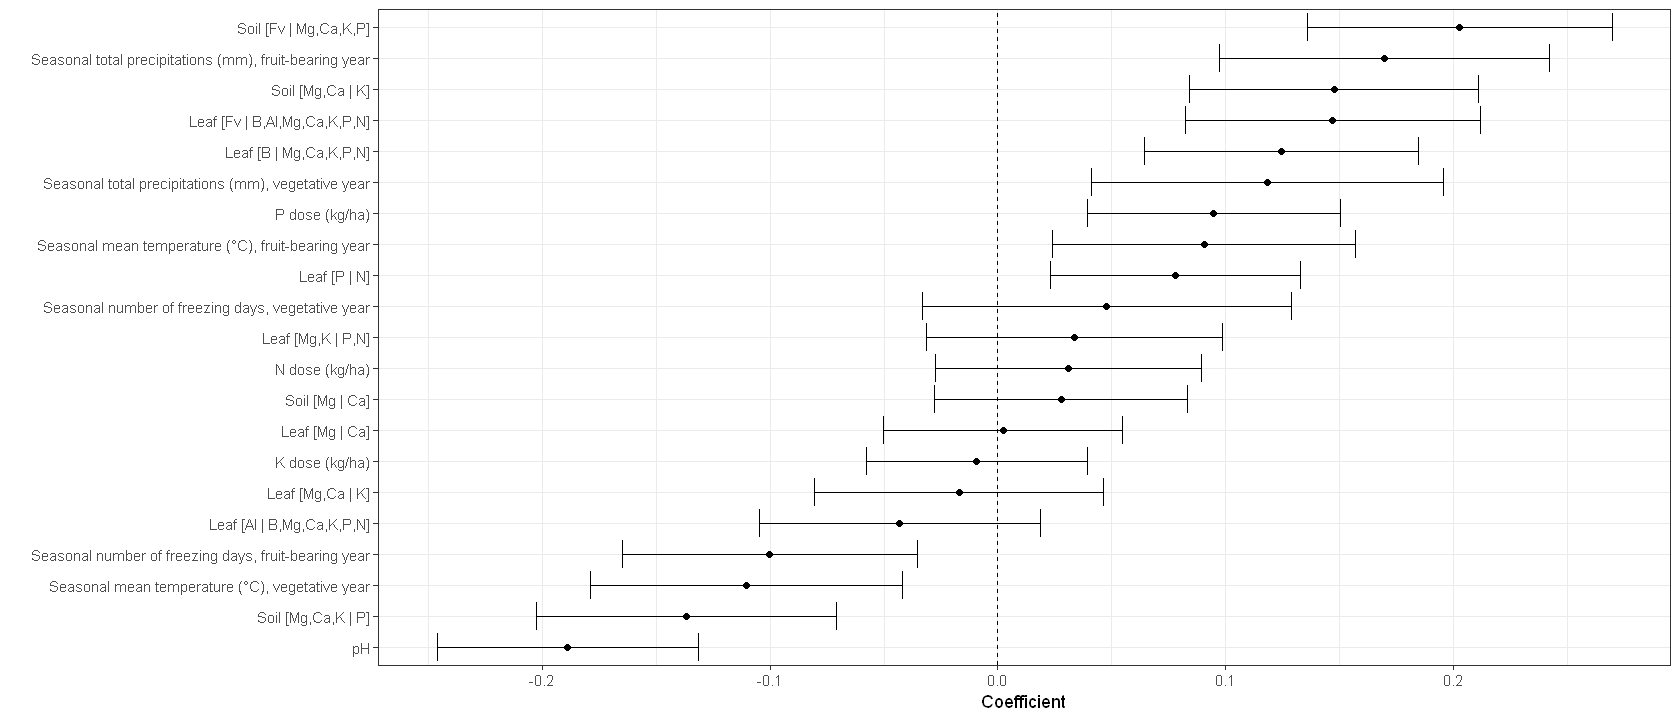

In [48]:
translate_df <- read_csv("data/translate_names.csv")

tidy(lm_freq, conf.int = TRUE) %>%
  filter(term != "(Intercept)") %>%
  left_join(translate_df, by = "term") %>%
  mutate(english = fct_reorder(english, estimate)) %>%
  ggplot(aes(estimate, english)) +
  geom_vline(xintercept = 0, linetype = 2) +
  geom_point() +
  geom_errorbarh(aes(xmin = conf.low, xmax = conf.high)) +
  labs(x = "Coefficient", y = "") +
  theme_bw() +
  ggsave("images/modlin-freq_seasonal.png", width = 6, height = 6, dpi = 300)

#### Bayesian framework

In [49]:
library("rstanarm")
library("tidybayes")
library("bayesplot")

lm_bayes <- stan_glm(
  linmod_formula,
  data = juice(df_stats_recipe),
  family = gaussian(),
  prior = normal(0, 10),
  prior_intercept = normal(0, 10),
  iter = 4000,
  warmup = 1000,
  cores = 4,
  seed = 9265830
)

Loading required package: Rcpp


Attaching package: 'Rcpp'


The following object is masked from 'package:rsample':

    populate


rstanarm (Version 2.19.3, packaged: 2020-02-11 05:16:41 UTC)

- Do not expect the default priors to remain the same in future rstanarm versions.

Thus, R scripts should specify priors explicitly, even if they are just the defaults.

- For execution on a local, multicore CPU with excess RAM we recommend calling

options(mc.cores = parallel::detectCores())

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting


Attaching package: 'rstanarm'


The following object is masked from 'package:compositions':

    R2



Attaching package: 'tidybayes'


The following object is masked from 'package:tune':

    parameters


The following object is masked from 'package:dials':

    parameters


This is bayesplot version 1.7.1

- Online documentation and vignettes at mc

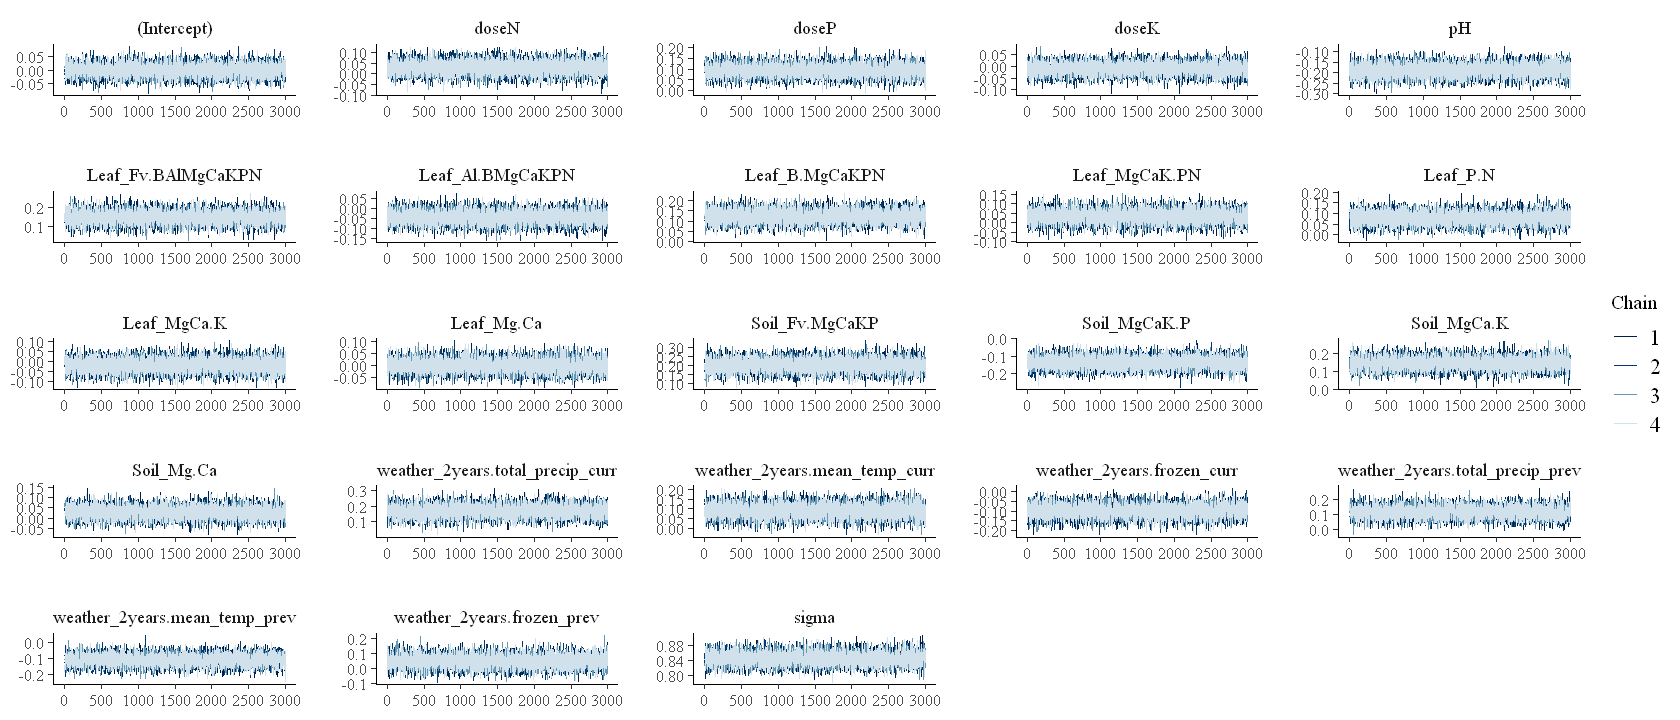

In [50]:
mcmc_trace(lm_bayes)

All caterpillars have constant noise. This is what we want.

Warning message:
"`expand_scale()` is deprecated; use `expansion()` instead."
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



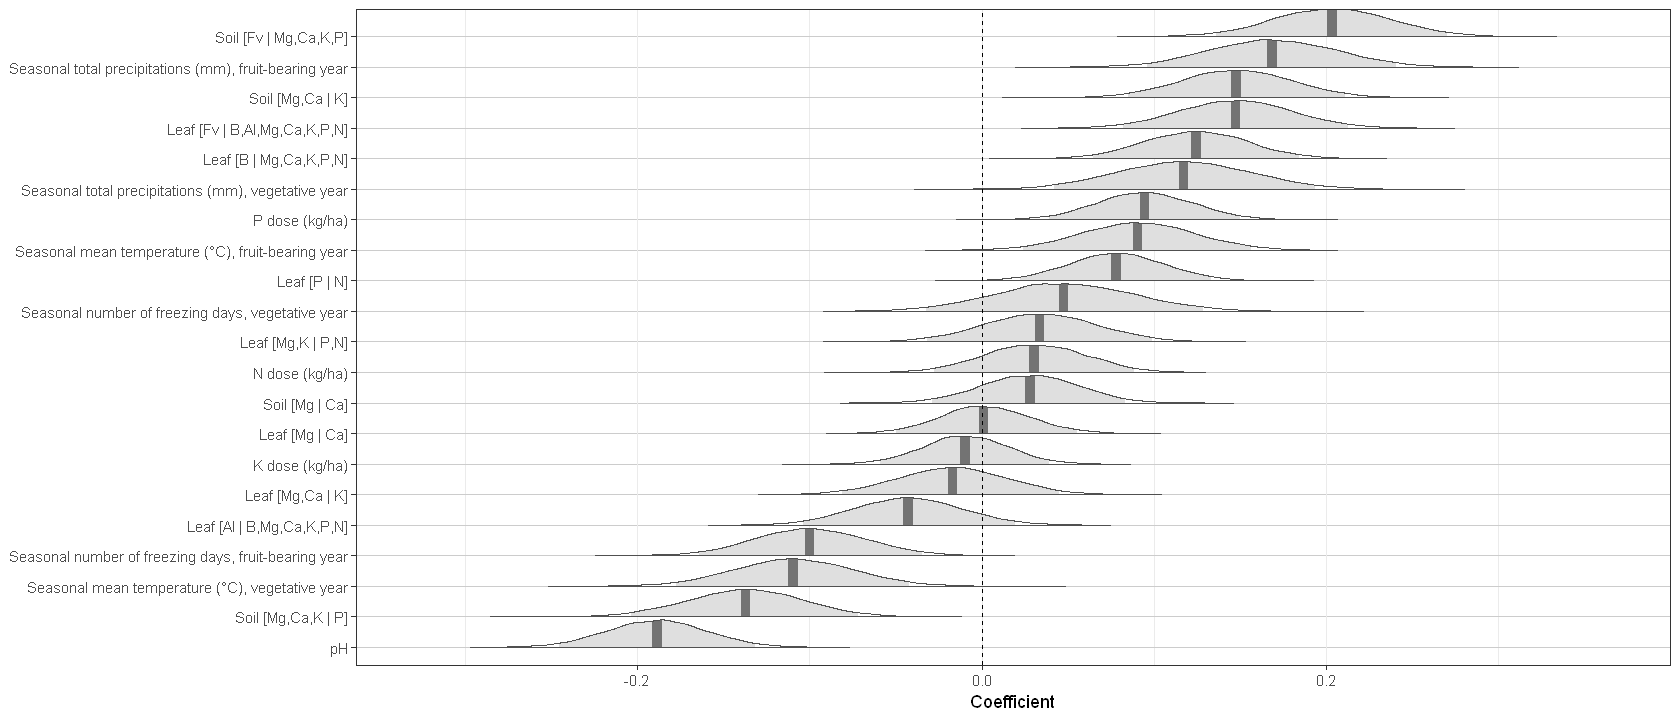

In [51]:
lm_summary <- tibble(
  term = names(lm_bayes$coefficients)[-1],
  coefficient = lm_bayes$coefficients[-1]
) %>%
  left_join(translate_df, by = "term")

color_scheme_set("gray")
mcmc_areas(
    lm_bayes,
    prob = 0.95,
    pars = lm_summary$term[order(lm_summary$coefficient, decreasing = FALSE)],
    area_method = "equal height"
  ) +
  geom_vline(xintercept = 0, linetype = 2) +
  labs(x = "Coefficient") +
  scale_y_discrete(
    labels = lm_summary$english[order(lm_summary$coefficient, decreasing = FALSE)]
  ) +
  theme_bw() +
  theme(panel.grid.major.y = element_line(colour = "grey80")) +
  ggsave("images/modlin-bayes_seasonal.png", width = 8, height = 5, dpi = 300)

### Weather current

In this section we investigate the effect of several variables where weather is considered only in the current year, on a monthly basis.

In [52]:
df_stats <- df_ %>%
  select(
    `Berry yield (kg/ha)`,
    `N dose (kg/ha)`,
    `P dose (kg/ha)`,
    `K dose (kg/ha)`,
    `pH H2O`,
    starts_with("Leaf_"),
    starts_with("Soil_"),
    starts_with("weather_current"),
    # Random effects
    Year, Site, Block
  ) %>%
  rename(
    yield = `Berry yield (kg/ha)`,
    doseN = `N dose (kg/ha)`,
    doseP = `P dose (kg/ha)`,
    doseK = `K dose (kg/ha)`,
    pH = `pH H2O`
  ) %>%
  drop_na()

In [53]:
linmod_formula <- yield ~ doseN + doseP + doseK + pH +
  Leaf_Fv.BAlMgCaKPN + Leaf_Al.BMgCaKPN + Leaf_B.MgCaKPN + 
  Leaf_MgCaK.PN + Leaf_P.N + Leaf_MgCa.K + Leaf_Mg.Ca +
  Soil_Fv.MgCaKP + Soil_MgCaK.P + Soil_MgCa.K + Soil_Mg.Ca +
  weather_current.total_precip_04 + weather_current.total_precip_05 + weather_current.total_precip_06 +
  weather_current.total_precip_07 + weather_current.total_precip_08 +
  weather_current.mean_temp_04 + weather_current.mean_temp_05 + weather_current.mean_temp_06 +
  weather_current.mean_temp_07 + weather_current.mean_temp_08 + 
  weather_current.frozen_04 + weather_current.frozen_05
#+ weather_current.frozen_06 +
#weather_current.frozen_07 + weather_current.frozen_08
#weather_current.toowarm_04 + weather_current.toowarm_05 + 
#weather_current.toowarm_06# +
#weather_current.toowarm_07# +
#weather_current.toowarm_08 +
#weather_current.GDD

df_stats_recipe <-
  df_stats %>%
  recipe(linmod_formula) %>%
  step_log(all_outcomes(), base = 10) %>% 
  step_normalize(-all_outcomes(), all_numeric()) %>%
  prep()

#### Frequential framework

In [54]:
lm_freq <- lm(linmod_formula, data = juice(df_stats_recipe))

Parsed with column specification:
cols(
  term = col_character(),
  english = col_character()
)



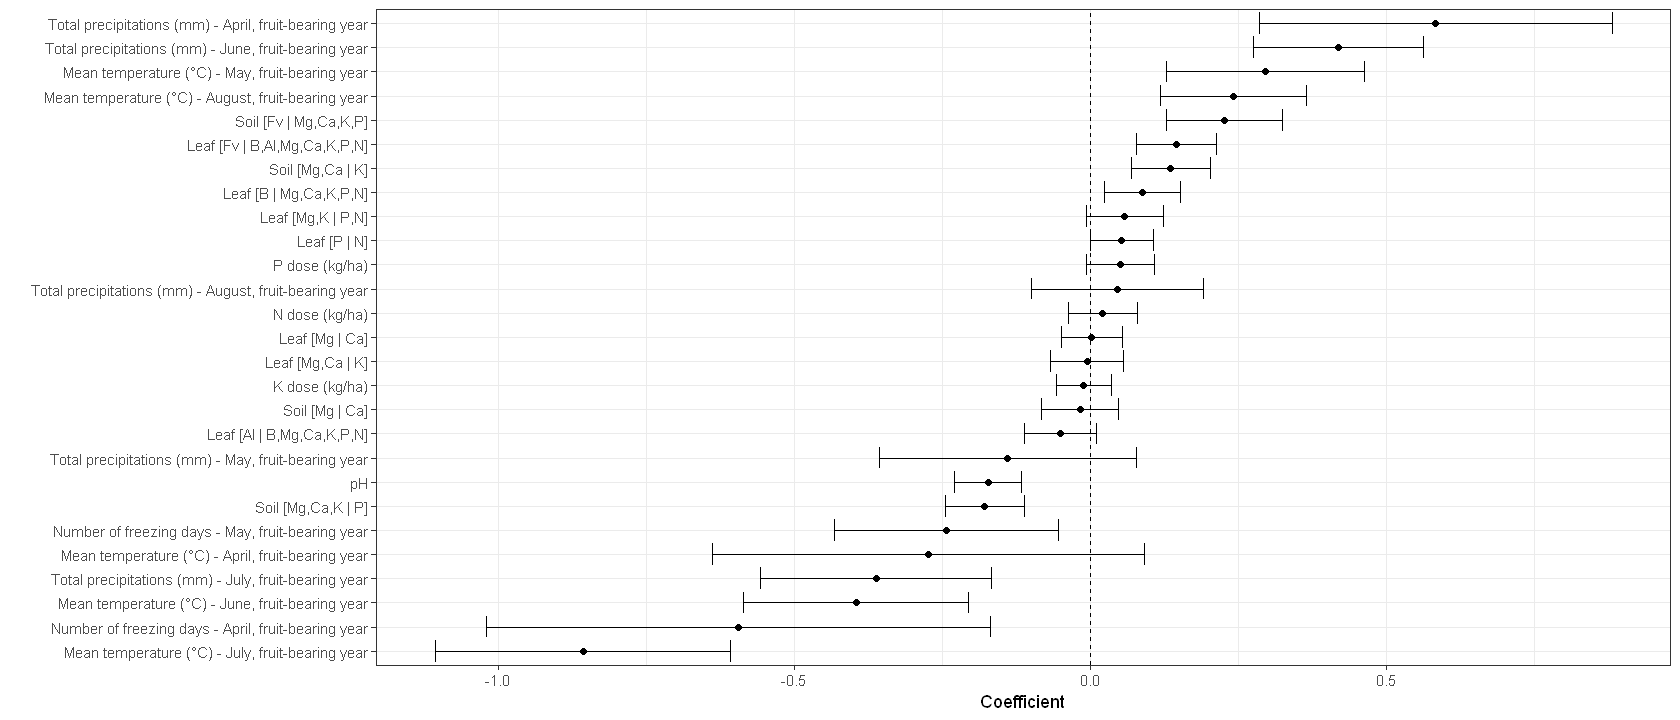

In [55]:
translate_df <- read_csv("data/translate_names.csv")

tidy(lm_freq, conf.int = TRUE) %>%
  filter(term != "(Intercept)") %>%
  left_join(translate_df, by = "term") %>%
  mutate(english = fct_reorder(english, estimate)) %>%
  ggplot(aes(estimate, english)) +
  geom_vline(xintercept = 0, linetype = 2) +
  geom_point() +
  geom_errorbarh(aes(xmin = conf.low, xmax = conf.high)) +
  labs(x = "Coefficient", y = "") +
  theme_bw() +
  ggsave("images/modlin-freq_monthly.png", width = 6, height = 6, dpi = 300)

#### Bayesian framework

In [56]:
library("rstanarm")
library("tidybayes")
library("bayesplot")

lm_bayes <- stan_glm(
  linmod_formula,
  data = juice(df_stats_recipe),
  family = gaussian(),
  prior = normal(0, 10),
  prior_intercept = normal(0, 10),
  iter = 4000,
  warmup = 1000,
  cores = 4,
  seed = 8578234
)

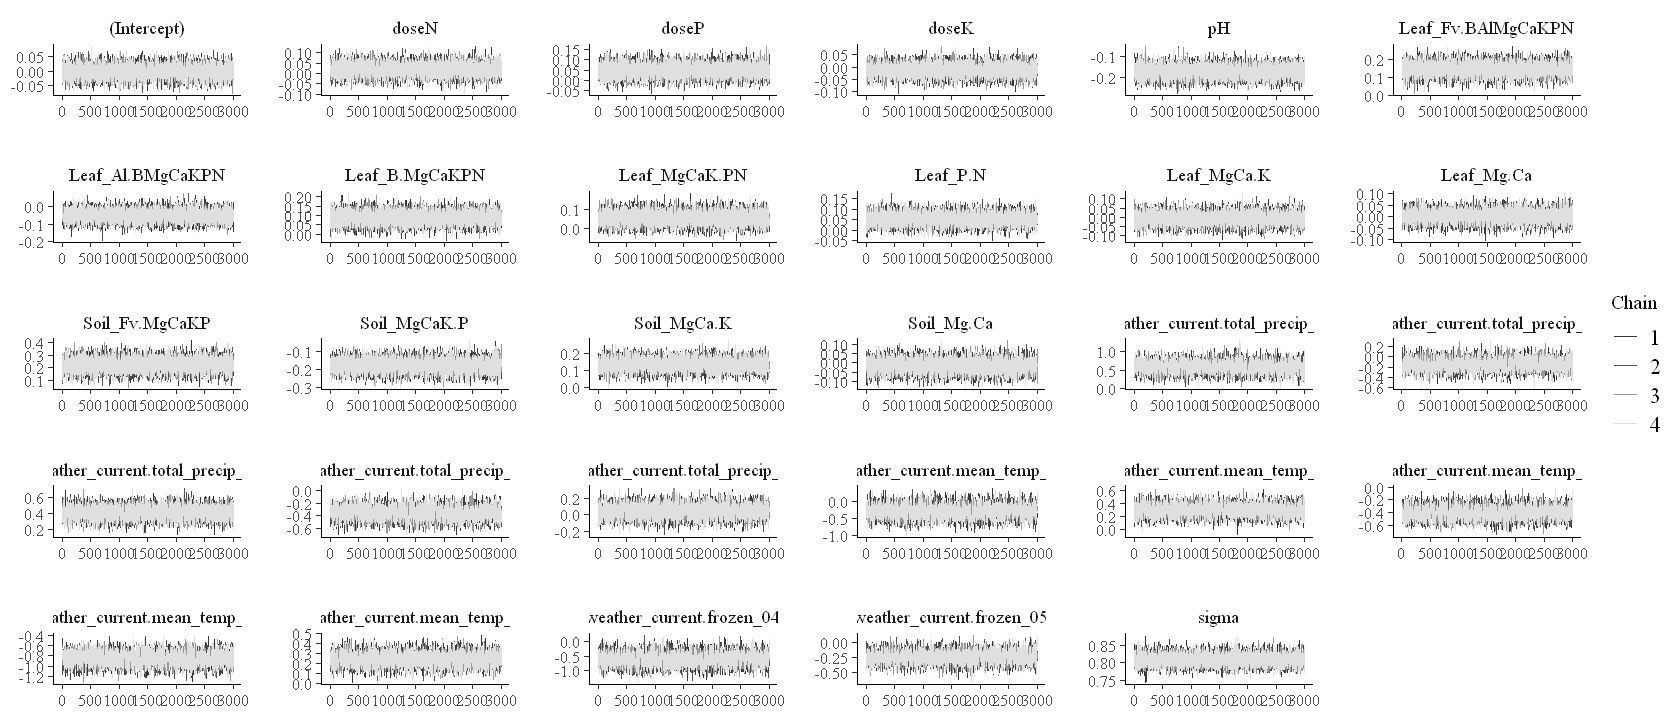

In [57]:
mcmc_trace(lm_bayes)

All caterpillars have constant noise. This is what we want.

Warning message:
"`expand_scale()` is deprecated; use `expansion()` instead."
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



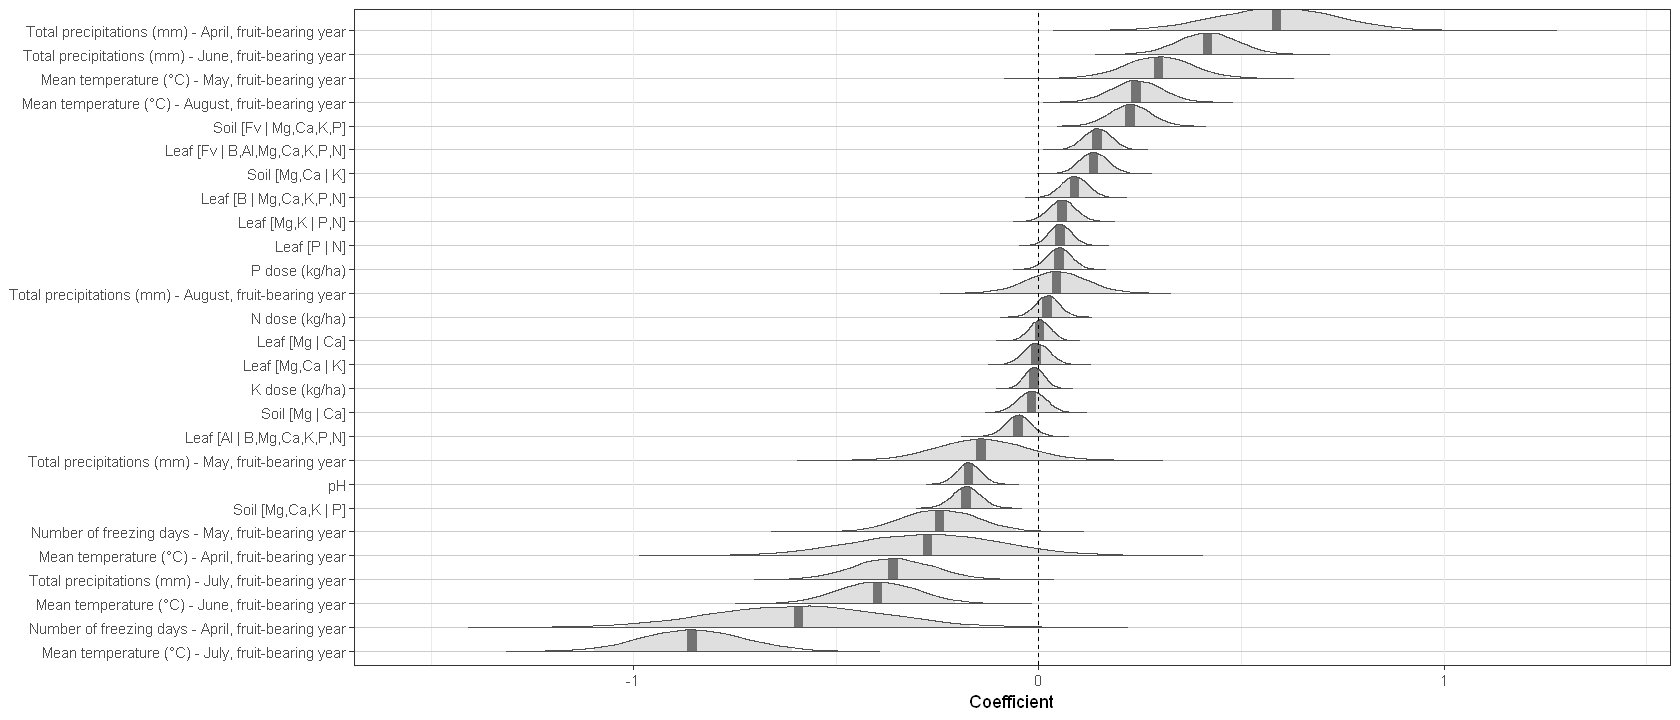

In [58]:
lm_summary <- tibble(
  term = names(lm_bayes$coefficients)[-1],
  coefficient = lm_bayes$coefficients[-1]
) %>%
  left_join(translate_df, by = "term")

color_scheme_set("gray")
mcmc_areas(
    lm_bayes,
    prob = 0.95,
    pars = lm_summary$term[order(lm_summary$coefficient, decreasing = FALSE)],
    area_method = "equal height"
  ) +
  geom_vline(xintercept = 0, linetype = 2) +
  labs(x = "Coefficient") +
  scale_y_discrete(
    labels = lm_summary$english[order(lm_summary$coefficient, decreasing = FALSE)]
  ) +
  theme_bw() +
  theme(panel.grid.major.y = element_line(colour = "grey80")) +
  ggsave("images/modlin-bayes_monthly.png", width = 8, height = 5, dpi = 300)

## Predictive modelling

While the previous models aimed at investigating effects, the model developped in this section aims at predicting outcomes.

I throw a random seed to make sure that the notebook can be reproduced.

In [59]:
set.seed(3174806) # random.org

Molelling yield from the NPK dosage and soil conditions

In [60]:
df_npk <- df_ %>%
  select(
    `Berry yield (kg/ha)`,
    `N dose (kg/ha)`,
    `P dose (kg/ha)`,
    `K dose (kg/ha)`,
    `pH H2O`,
    starts_with("Leaf_"),
    starts_with("Soil_"),
    starts_with("weather_before")
  ) %>%
  rename(
    yield = `Berry yield (kg/ha)`,
    doseN = `N dose (kg/ha)`,
    doseP = `P dose (kg/ha)`,
    doseK = `K dose (kg/ha)`,
    pH = `pH H2O`
  ) %>%
  drop_na()

In [61]:
df_npk <- df_npk %>% 
  select(-weather_before.frozen_04, -weather_before.frozen_05,
         -weather_before.frozen_06, -weather_before.frozen_07, -weather_before.frozen_08,
         -weather_before.toowarm_04, -weather_before.toowarm_05, -weather_before.toowarm_06,
         -weather_before.toowarm_07, -weather_before.toowarm_08, -weather_before.GDD_before,
        -doseN, -doseP, -doseK)

Train / test split.

In [62]:
npk_split <- initial_split(df_npk, prop = 3 / 4)

npk_train <- training(npk_split)
npk_test <- testing(npk_split)

Preprocessing recipe.

In [63]:
npk_recipe <- npk_train %>%
  recipe(yield ~ .) %>%
  #step_log(all_outcomes(), base = 10) %>% # toggle
  step_normalize(all_numeric()) %>%
  #step_inverse(all_outcomes()) %>% # toggle
  prep()

#mean_logy <- mean(log10(npk_train$yield)) # toggle
#sd_logy <- sd(log10(npk_train$yield)) # toggle

mean_y <- mean(npk_train$yield)
sd_y <- sd(npk_train$yield)

# the recipes package does not allow backtransformation yet
# https://github.com/tidymodels/recipes/issues/264

step_back <- function(y) {
  #y <- 1/y # toggle
  #y <- 10 ^ (y * sd_logy + mean_logy) # toggle
  y <- y * sd_y + mean_y
  return(y)
}

train_baked <- bake(npk_recipe, npk_train)
test_baked <-  bake(npk_recipe, npk_test)

write_csv(x = train_baked, path = "output/train_baked.csv")
write_csv(x = test_baked, path = "output/test_baked.csv")

### Variable importance

Variable importance in the model can be assessed with extreme gradient boosted tree modeling with **`caret`**.

In [64]:
library("caret")
set.seed(2779781) # random.org

train_control <- trainControl(
  method = "repeatedcv",
  number = 3
)

# These parameters minimise bias and return similar R² in training
# and testing
tune_xgb <- expand.grid( # xgbTree
  nrounds = 50, # not too much to avoid overfit
  max_depth = 2, #c(1, 2, 4, 6, 8, 10), # few avoids overfit
  eta = 0.25, #c(0.001, 0.01, 0.1), # not too high to avoid bias
  gamma = 1,
  colsample_bytree = 0.75,
  min_child_weight = 7, #c(3, 5, 7)
  subsample = 0.95#c(0.3, 0.5, 0.8) # too high or too low can create a bias
)

Loading required package: lattice


Attaching package: 'caret'


The following objects are masked from 'package:rstanarm':

    compare_models, R2


The following object is masked from 'package:compositions':

    R2


The following objects are masked from 'package:yardstick':

    precision, recall, sensitivity, specificity


The following object is masked from 'package:purrr':

    lift




In [65]:
m_fit <- train(yield ~ .,
               data = train_baked,
               method = "xgbTree",
               trControl = train_control,
               tuneGrid = tune_xgb,
               verbose = FALSE
)

Quick actual-predicted check.

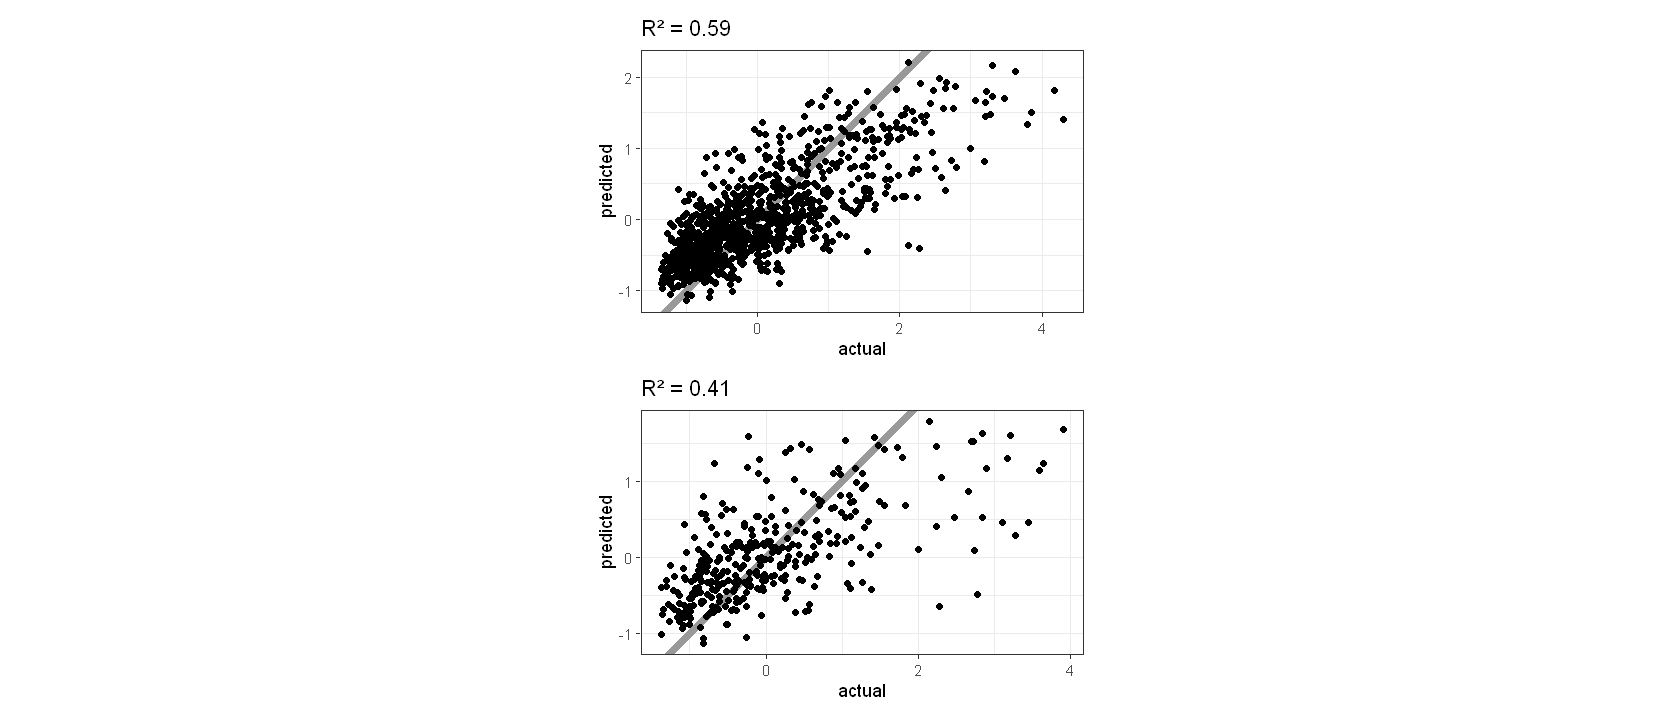

In [66]:
library("patchwork")

rsq_tr <- cor(train_baked$yield, predict(m_fit))^2
rsq_te <- cor(test_baked$yield, predict(m_fit, newdata = test_baked))^2

gg_tr <- tibble(actual = train_baked$yield,
       predicted = predict(m_fit)) %>%
  ggplot(aes(x = actual, y = predicted)) +
  geom_abline(slope = 1, intercept = 0, colour = "gray60", lwd = 2) +
  geom_point() +
  labs(title = paste("R² =", round(rsq_tr, 2))) +
  theme_bw() +
  coord_equal()

gg_te <- tibble(actual = test_baked$yield,
       predicted = predict(m_fit, newdata = test_baked)) %>%
  ggplot(aes(x = actual, y = predicted)) +
  geom_abline(slope = 1, intercept = 0, colour = "gray60", lwd = 2) +
  geom_point() +
  labs(title = paste("R² =", round(rsq_te, 2))) +
  theme_bw() +
  coord_equal()

gg_tr / gg_te

Importance of variables in the model.

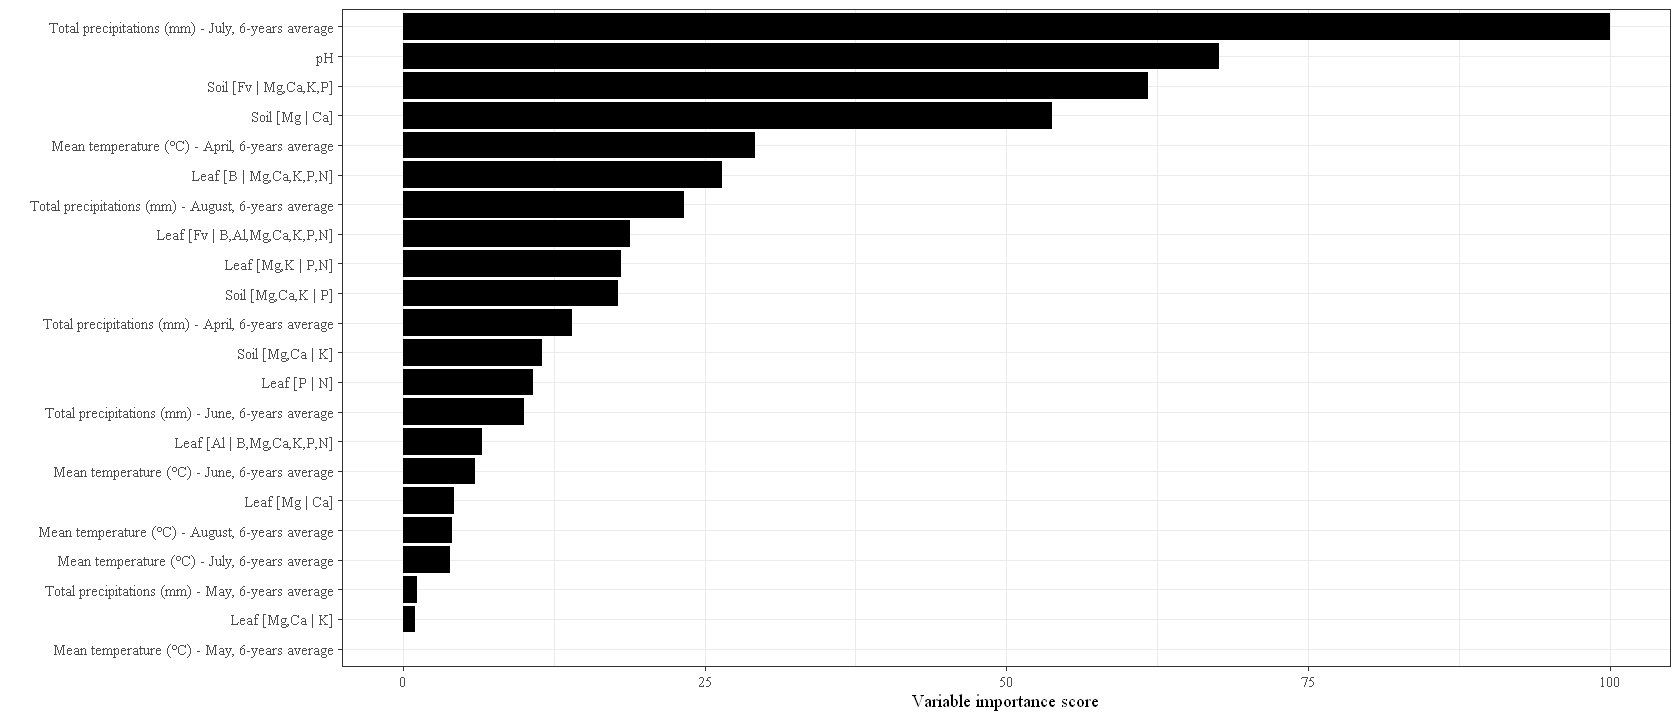

In [67]:
tibble(
  term = rownames(varImp(m_fit)$importance),
  score = varImp(m_fit)$importance[, 1]
) %>%
  left_join(translate_df, by = "term") %>%
  mutate(english = fct_reorder(factor(english), score)) %>%
  ggplot(aes(y = score, x = english)) +
  geom_bar(stat = "identity", fill = "black", lwd = 0) +
  labs(x = "", y = "Variable importance score") +
  coord_flip() +
  theme_bw() +
  theme(text=element_text(family="serif")) +
  ggsave("images/varimp.png", width = 6, height = 5, dpi = 300)

⚠️ Feature importance changes widely by changing the random seeds. It is considered exploratory, but not reliable.

### Prediction model

Variable importance can't be assessed with Gaussian processes, which is a great tool to model smooth phenomenons like those occuring in agroecosystems ([Coulibali et al. 2020](https://doi.org/10.1101/2020.03.12.988626)).

In [68]:
tune_gp <- expand.grid( # gaussprRadial
  sigma = 0.1#c(0.05, 0.1, 0.15, 0.2)
)

m_fit <- train(yield ~ .,
               data = train_baked,
               method = "gaussprRadial",
               trControl = train_control,
               tuneGrid = tune_gp,
               verbose = FALSE
)

Create tables to plot observed vs predicted.

In [69]:
train_pred <- tibble(
  yield = npk_train$yield,
  pred = step_back(predict(m_fit, newdata = bake(npk_recipe, npk_train)))
)

test_pred <- tibble(
  yield = npk_test$yield,
  pred = step_back(predict(m_fit, newdata = bake(npk_recipe, npk_test)))
)

rsq_tr <- cor(train_pred$yield, train_pred$pred)^2
rsq_te <- cor(test_pred$yield, test_pred$pred)^2

Plot observed vs predicted.

Saving 6.67 x 6.67 in image



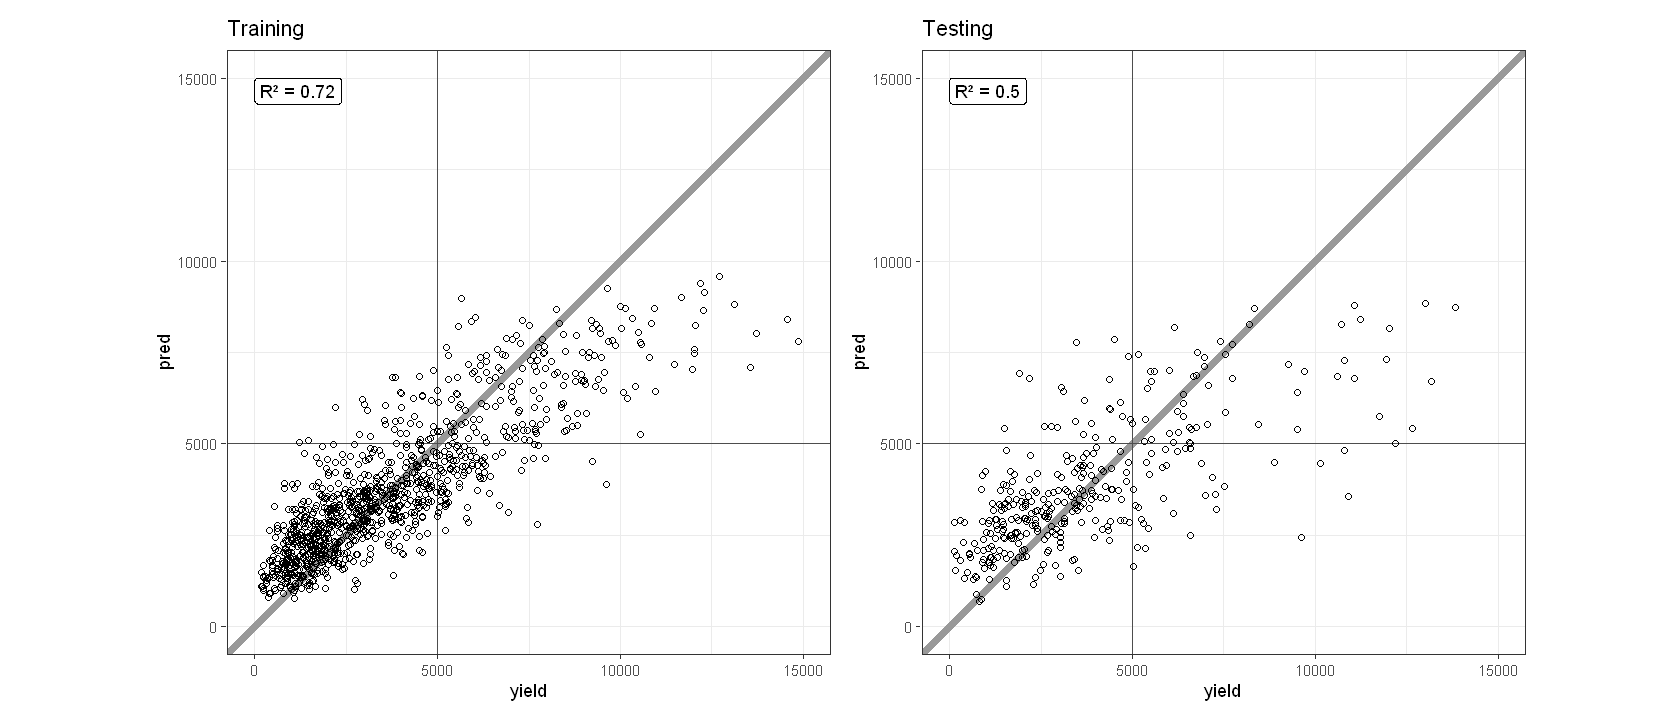

In [70]:
delimiter <- 5000
gg_pred_f <- function(data, rsq, title) {
  data %>%
    ggplot(aes(x = yield, y = pred)) +
    geom_abline(slope = 1, intercept = 0, colour = "gray60", lwd = 2) +
    geom_vline(xintercept = delimiter, colour = "gray30") +
    geom_hline(yintercept = delimiter, colour = "gray30") +
    geom_label(x = 0, y = 15000,
               vjust = 1, hjust = 0,
               label = paste("R² =", signif(rsq, 2))) +
    geom_point(pch = 1) +
    labs(title = title) +
    expand_limits(x = c(0, 15000), y = c(0, 15000)) +
    coord_equal() +
    theme_bw()# +
    #theme(text=element_text(family="serif"))
}

gg_training <- gg_pred_f(train_pred, rsq_tr, "Training")
gg_testing <- gg_pred_f(test_pred, rsq_te, "Testing")

gg_training + gg_testing

ggsave("images/modpred.png")

Binary classification.

In [71]:
delimiter <- 5000
test_bc <- test_pred %>%
  mutate(
    yield = case_when(
      yield >= delimiter ~ "HY",
      TRUE ~ "LY"
    ),
    pred = case_when(
      pred >= delimiter ~ "HY",
      TRUE ~ "LY"
    )
  )
test_cm <- table(test_bc)
print("Accuracy")
(test_cm[1, 1] + test_cm[2, 2]) / sum(test_cm)
print("PPV")
test_cm[2, 2] / sum(test_cm[2, ])
print("NPV")
test_cm[1, 1] / sum(test_cm[1, ])

[1] "Accuracy"


[1] 0.8381503

[1] "PPV"


[1] 0.9073359

[1] "NPV"


[1] 0.6321839

# Predictive modelling usage on the ionome

We use a seed to assure reproducibility.

In [72]:
set.seed(5442451) # random.org

We randomly sample a low performing site whose ionome should be investigated, extract its ionome and predict its yield.

In [73]:
misbal_observation <- df_npk %>% 
  filter(yield < 3000) %>% 
  sample_n(1)

ref_leaf <- misbal_observation %>% 
  select(starts_with("Leaf")) %>% 
  unlist()

yield_init <- step_back(predict(m_fit, newdata = bake(npk_recipe, misbal_observation)))

I recall the original table to recover the ID of the randomly selected observation.

In [74]:
observation_id <- df_source %>%
  filter(`Berry yield (kg/ha)` == misbal_observation$yield,
         `pH H2O` == misbal_observation$pH) %>%
  pull(id)
print(paste0("The randomly selection row ID is ", observation_id, "."))

[1] "The randomly selection row ID is 963."


We set convergence parameters. `max_iter` is the number of steps in the Markov chain. The `radius` is the Aitchison distance where to scan around the point at each step. The initial radius, `radius[1]` is also the base radius, i.e. if a point with better yield is found, the radius goes back to this initial radius (`radius[1]`), else it is multiplied by `radius_factor` to enlarge scanning. Finally `n_rad` is the number of points to sample around the ionome of the preceeding step.

In [75]:
max_iter <- 10 
radius <- c(0.5)
radius_factor <- 1.25 # for adaptative search
radius_limits <- c(0.5, 1.5)
## if the max is too high, all explored ionome risk to be filtered out due
## to extrapolation (see Mahalanobis distance below). The upper limit
## should be set in relation to the p in qchisq below.
n_rad <- 10000

To scan around a point, we create a matrix with the number of columns defined by the number of balances in the ionome and the number of rows defined by `n_rad`, and fill it with random numbers. Each row is normalized to have a norm equal to the radius. 

To acheive the prediction, we need the ionome, but also other variables that are kept constant. This information is extracted in a table, then replicated `n_rad` times to be binded further on to the perturbed ionomes scanned around the best ionome.

In [76]:
misbal_observation_noleaf <- misbal_observation %>% 
  select(-starts_with("Leaf")) %>%
  slice(rep(row_number(), n_rad))

We initialize the yield and the ionome.

In [77]:
ref_yield <- c(yield_init)
ref_leaf <- matrix(ncol = nrow(sbp_leaf), nrow = max_iter)

ref_leaf[1, ] <- misbal_observation %>% 
  select(starts_with("Leaf")) %>% 
  unlist()

We use a mahalanobis distance to ensure that the algorithm doesn't explore too far from the theoretical multivariate normal distribution of the ionome. To compute the Mahalanobis distance, we need the mean, the (invert) covariance and a critical (squared) distance.

In [78]:
bal_mean <- apply(bal_leaf %>% select(-id), 2, mean)
bal_icov <- solve(cov(bal_leaf %>% select(-id)))
crit_dist <- qchisq(p = 0.999, df = length(bal_mean))

... and fire the Markov chain.

[1] "Iteration 2 - yield improved to 4460.23641827547"
[1] "Iteration 3 - yield improved to 4672.5081884298"
[1] "Iteration 4 - yield improved to 4744.49775161753"
[1] "Iteration 5 - yield improved to 4751.64196133433"
[1] "Iteration 6 - yield improved to 4757.50684259842"
[1] "Iteration 7 - no yield improvement."
[1] "Iteration 8 - no yield improvement."
[1] "Iteration 9 - no yield improvement."
[1] "Iteration 10 - no yield improvement."


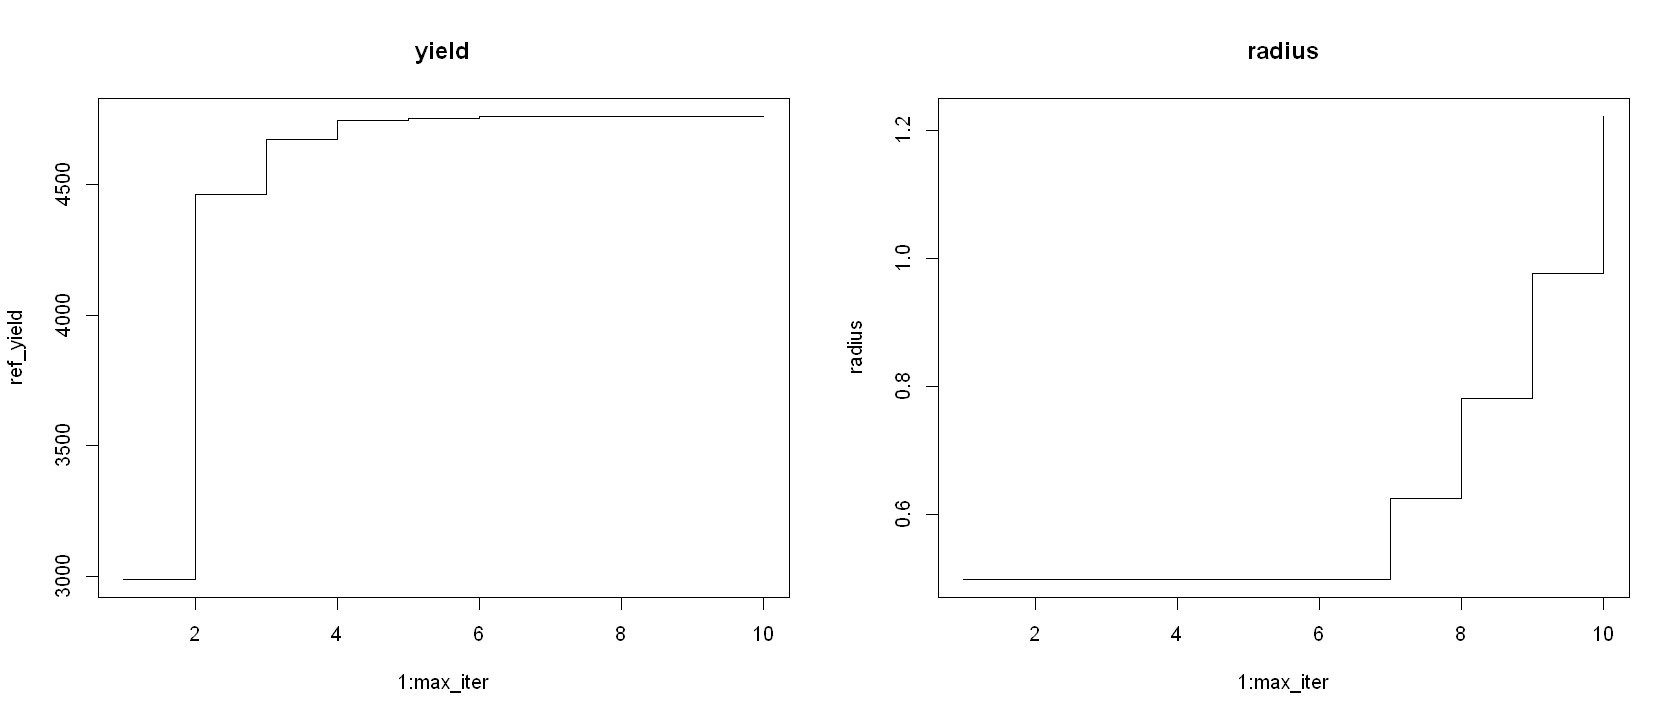

In [79]:
for (i in 2:max_iter) {
  # print(paste(i, "/", max_iter))
  offset <- matrix(runif(ncol(ref_leaf) * n_rad, -1, 1), 
                   ncol = ncol(ref_leaf),
                   nrow = n_rad)
  offset <- t(apply(offset, 1, function(x) radius[i-1] * x / sqrt(sum(x^2))))
  offset <- offset * runif(length(offset), 0, 1)
  leaf_search <- t(apply(offset, 1, function(x) x + ref_leaf[i-1, ] ))
  
  # Compute the Mahalanobis distance
  maha_dist <- mahalanobis(leaf_search, bal_mean, bal_icov, inverted = TRUE)
  # filter out search ionomes outside the Mahalanobis distance limit
  leaf_search <- data.frame(leaf_search) %>% filter(maha_dist < crit_dist)
  
  names(leaf_search) <- paste0("Leaf_", leaf_bal_def)
                         
  df_search <- leaf_search %>% 
    bind_cols(misbal_observation_noleaf %>% filter(maha_dist < crit_dist))
    
  if(nrow(df_search) == 0) { # if no points are generated in the hyper ellipsoid, keep the reference but increase radius
    print(paste("Iteration", i, "- all points are out of the hyperellipsoid."))
    ref_yield[i] <- ref_yield[i-1]
    ref_leaf[i, ] <- ref_leaf[i-1, ]
    # increase the radius
    radius[i] <- radius[i - 1] * radius_factor
    radius[i] <- ifelse(radius[i] > radius_limits[2], radius_limits[2], radius[i])
  } else {
    # Compute predicted yield
    yield_stochastic <- step_back(predict(m_fit, newdata = bake(npk_recipe, df_search)))
    if(max(yield_stochastic) > ref_yield[i-1]) {
      print(paste("Iteration", i, "- yield improved to", max(yield_stochastic)))
      ref_yield[i] <- max(yield_stochastic)
      ref_leaf[i, ] <- leaf_search[which.max(yield_stochastic), ] %>% 
        unlist()
      # decrease the radius
      radius[i] <- radius[i - 1] / radius_factor
      radius[i] <- ifelse(radius[i] < radius_limits[1], radius_limits[1], radius[i])
    } else {
      print(paste("Iteration", i, "- no yield improvement."))
      ref_yield[i] <- ref_yield[i-1]
      ref_leaf[i, ] <- ref_leaf[i-1, ]
      # increase the radius
      radius[i] <- radius[i - 1] * radius_factor
      radius[i] <- ifelse(radius[i] > radius_limits[2], radius_limits[2], radius[i])
    }
  }
}

par(mfrow = c(1, 2))
plot(1:max_iter, ref_yield, type = 's', main = "yield")
plot(1:max_iter, radius, type = 's', main = "radius")

At each step, balances are transformed back to the concentration scale.

In [80]:
ref_leaf_comp <- ilrInv(ref_leaf,
                        V = gsi.buildilrBase(t(sbp_leaf))) %>% 
  data.frame()

We then create a decent table able to be plotted.

In [81]:
gg_iter <- bind_cols(
  ref_leaf_comp,
  tibble(yield = ref_yield, iteration = 1:max_iter)
) %>% 
  pivot_longer(
    cols = -iteration,
    names_to = "variables",
    values_to = "values"
  ) %>% 
  mutate(values = case_when(variables != "yield" ~ values * 100,
                            TRUE ~ values), # concentrations in %
         units = case_when(variables == "yield" ~ "kg/ha",
                           TRUE ~ "%")) # units

We extract points obtained at the first iteration and at the end to plot points and labels.

In [82]:
gg_iter_extremes <- gg_iter %>% 
  filter(iteration %in% c(1, max_iter))

The following block extracts min and max of the concentrations in the training set.

In [83]:
bal_train <- npk_train %>% 
  select(starts_with("Leaf")) 
comp_train <- ilrInv(bal_train, V = gsi.buildilrBase(t(sbp_leaf))) %>% 
  data.frame()
comp_range <- comp_train %>% 
  mutate(id_tr = 1:nrow(.)) %>% 
  pivot_longer(cols = -id_tr, names_to = "variables",
               values_to = "value") %>% 
  group_by(variables) %>% 
  summarise(min = min(value),
            max = max(value)) %>% 
  pivot_longer(cols = -variables,
               names_to = "statistic",
               values_to = "value") %>% 
  mutate(value = value * 100)

Before going further, let's try another approach.

## Optimisation using `optim`

Regardless the path, we can look for the optimal ionome for this given condition using `optim`. We first need a function to minimize. We will minimize 1/yield while assuring that the ionome is not optimise outside its scope.

In [84]:
fr <- function(x, model) {
    new_data <- 
      misbal_observation %>%
      mutate(Leaf_Fv.BAlMgCaKPN = x[1],
             Leaf_Al.BMgCaKPN = x[2],
             Leaf_B.MgCaKPN = x[3],
             Leaf_MgCaK.PN = x[4],
             Leaf_P.N = x[5],
             Leaf_MgCa.K = x[6],
             Leaf_Mg.Ca = x[7])
    
    # make sur the point is not extrapolated
    maha_dist <- mahalanobis(
        new_data %>% select(starts_with("Leaf")),
        bal_mean, bal_icov, inverted = TRUE
    )
    
    output <- ifelse(
        maha_dist > crit_dist,
        1E6, # large value
        1/predict(model, newdata = bake(npk_recipe, new_data))
    )
    
    return(output)
}

I run the optimisation several times with different starting point generated from a theoretical multivariate normal distribution of the ionome.

In [85]:
set.seed(8066372) # random.org
n_sp <- 20 # number of starting points
opt_leaf <- list()
opt_value <- rep(0, n_sp)
for (i in 1:n_sp) {
    leaf_means <- df_npk %>%
      select(starts_with("Leaf")) %>%
    colMeans()
    leaf_cov <- df_npk %>%
      select(starts_with("Leaf")) %>%
    cov()
    sp <- MASS::mvrnorm(n = 1, leaf_means, leaf_cov)
    opt_leaf[[i]] <- optim(
        par = sp,
        fr,
        model = m_fit
    )
    opt_value[i] <- opt_leaf[[i]]$value
}

best_opt_leaf <- opt_leaf[[which.min(opt_value)]]

I extract the optimal ionome.

In [86]:
optim_ilr <- best_opt_leaf$par
optim_comp <- ilrInv(matrix(optim_ilr, nrow = 1),
       V = gsi.buildilrBase(t(sbp_leaf)))
optim_comp <- tibble(variables = names(optim_comp),
       values = t(unclass(optim_comp)) * 100,
       iteration = max_iter)

I predict the outcome from the optimal ionome.

In [87]:
new_data <- misbal_observation %>%
      mutate(Leaf_Fv.BAlMgCaKPN = optim_ilr[1],
             Leaf_Al.BMgCaKPN = optim_ilr[2],
             Leaf_B.MgCaKPN = optim_ilr[3],
             Leaf_MgCaK.PN = optim_ilr[4],
             Leaf_P.N = optim_ilr[5],
             Leaf_MgCa.K = optim_ilr[6],
             Leaf_Mg.Ca = optim_ilr[7])

optim_yield <- step_back(predict(m_fit, newdata = bake(npk_recipe, new_data)))

In [88]:
optim_comp <- optim_comp %>%
  add_row(variables = "yield", values = optim_yield, iteration = max_iter)

In [89]:
optim_comp

variables,values,iteration
<chr>,"<dbl[,1]>",<dbl>
N,2.105644e+00,10
P,1.394790e-01,10
K,4.848899e-01,10
Ca,2.777051e-01,10
Mg,1.079823e-01,10
Al,5.659254e-03,10
B,3.250686e-03,10
Fv,9.687539e+01,10
yield,3.688496e+03,10


## Markov-chain or `optim`?

And plot with a lot of pretty theming.

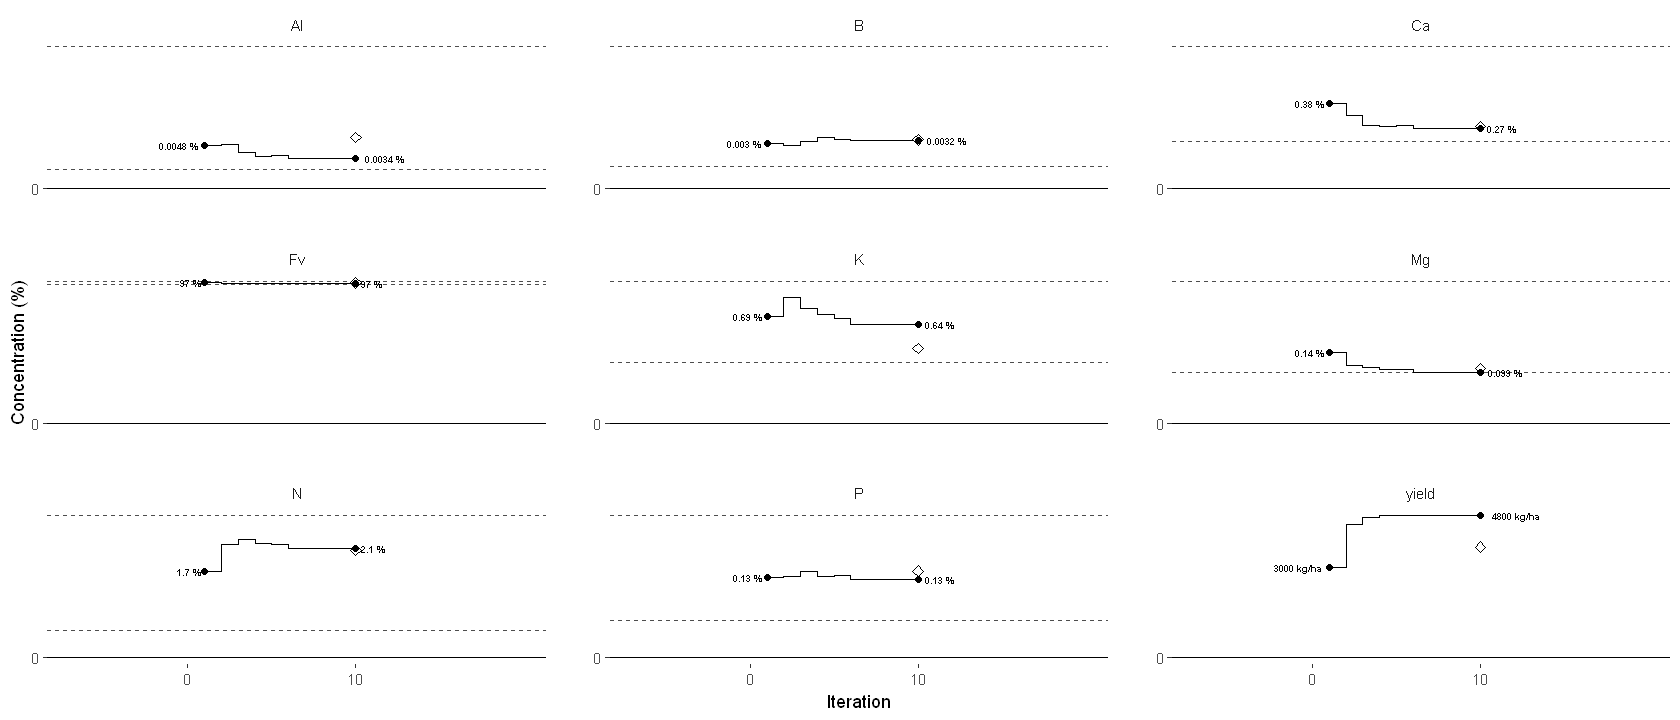

In [109]:
ggplot(gg_iter, aes(x = iteration, y = values)) +
  facet_wrap(~variables, scales = "free_y", ncol = 3) +
  geom_hline(data = comp_range,
             aes(group = statistic, yintercept = value),
             colour = "gray30", linetype = 2, lwd = 0.2) +
  geom_step() +
  geom_point(data = optim_comp, fill = "white", size = 2, pch = 23) +
  geom_point(data = gg_iter_extremes) +
  geom_text(data = gg_iter_extremes %>% filter(iteration == 1), 
            aes(label = paste(signif(values, 2), units)), 
            hjust = 1.15, 
            fontface = "bold", 
            size = 2) +
  geom_text(data = gg_iter_extremes %>% filter(iteration == max_iter), 
            aes(label = paste(signif(values, 2), units)), 
            hjust = -0.25, 
            fontface = "bold", 
            size = 2) +
  geom_hline(yintercept = 0) +
  expand_limits(x = c(-7, 20), y = 0) +
  scale_x_continuous(breaks = seq(0, max_iter, by = 10)) +
  labs(x = "Iteration", y = "Concentration (%)") +
  scale_y_continuous(breaks=0) +
  theme_bw() +
  theme(
    panel.spacing = unit(10, 'mm'),
    panel.grid = element_blank(),
    panel.border = element_blank(),
    strip.background = element_blank(),
    panel.grid.major.x = element_blank(),
    #text = element_text(family = "serif")
  ) +
  ggsave("images/convergence.png", height = 4, width = 6, dpi = 300)

Aitchison distance between observed and target.

In [91]:
print(
    paste(
        "AD between the observation and the target (using the Markpv chain)",
        sqrt(sum((ref_leaf[1, ] - ref_leaf[max_iter, ]) ^ 2))
    )
)

print(
    paste(
        "AD between the observation and the optimum (using optim)",
        sqrt(sum((ref_leaf[1, ] - optim_ilr) ^ 2))
    )
)

[1] "AD between the observation and the target (using the Markpv chain) 0.588085977881433"
[1] "AD between the observation and the optimum (using optim) 0.595634253091714"


Visualisation of the observed/target ratio for the path algorithm.

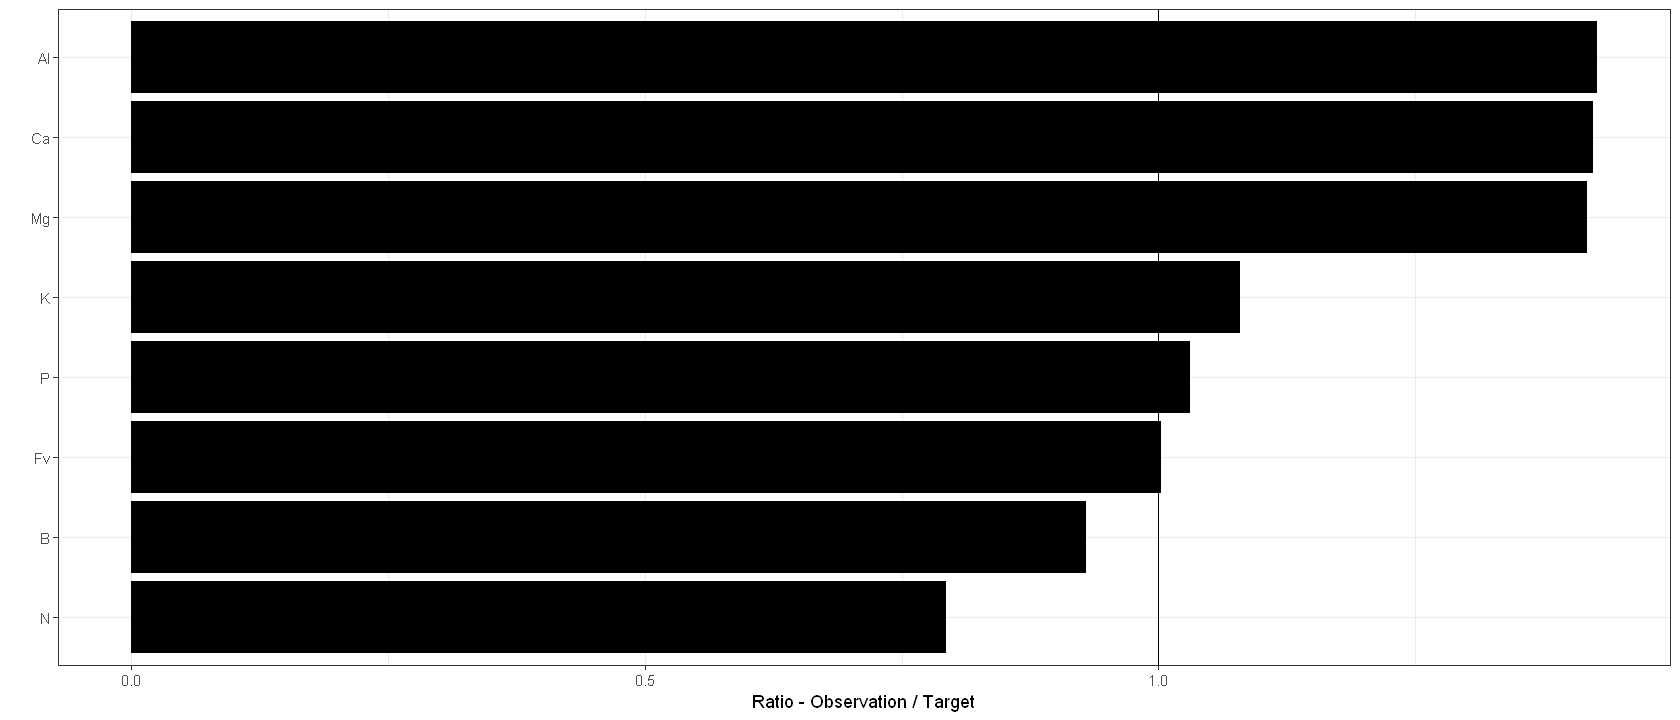

In [92]:
gg_iter_extremes %>%
  pivot_wider(names_from = iteration,
              values_from = values) %>% 
  mutate(ratio = `1` / `10`) %>% 
  filter(variables != "yield") %>% 
  mutate(variables = fct_reorder(variables, ratio)) %>% 
  ggplot(aes(y = ratio, x = variables)) +
  labs(x = "", y = "Ratio - Observation / Target") +
  geom_col(fill = "black") +
  geom_hline(yintercept = 1) +
  coord_flip() +
  theme_bw() #+
  #theme(text = element_text(family = "serif")) +
  ggsave("images/ratio.png", height = 2, width = 4, dpi = 300)

# Overview of optimal ionomes

The same code is applied to all observations in an external file to obtain overall statistics of targets.

In [93]:
load("output/opt.RData")

variable,min,q25,median,q75,max
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
N,1.111079752,1.875458402,2.002044348,2.125003224,2.65123298
P,0.069663698,0.123998725,0.133296372,0.149961730,0.25859033
K,0.426637801,0.565695341,0.631583146,0.678020733,0.98634165
Ca,0.255066456,0.344575143,0.403993772,0.453359149,0.68724189
Mg,0.093160337,0.147712250,0.170871197,0.199592376,0.29639947
B,0.001039717,0.002651542,0.003856003,0.004725661,0.01204839
Al,0.002012122,0.003768203,0.004749100,0.005993887,0.01399237
Fv,95.635159421,96.501945448,96.675883249,96.817054616,97.64939551


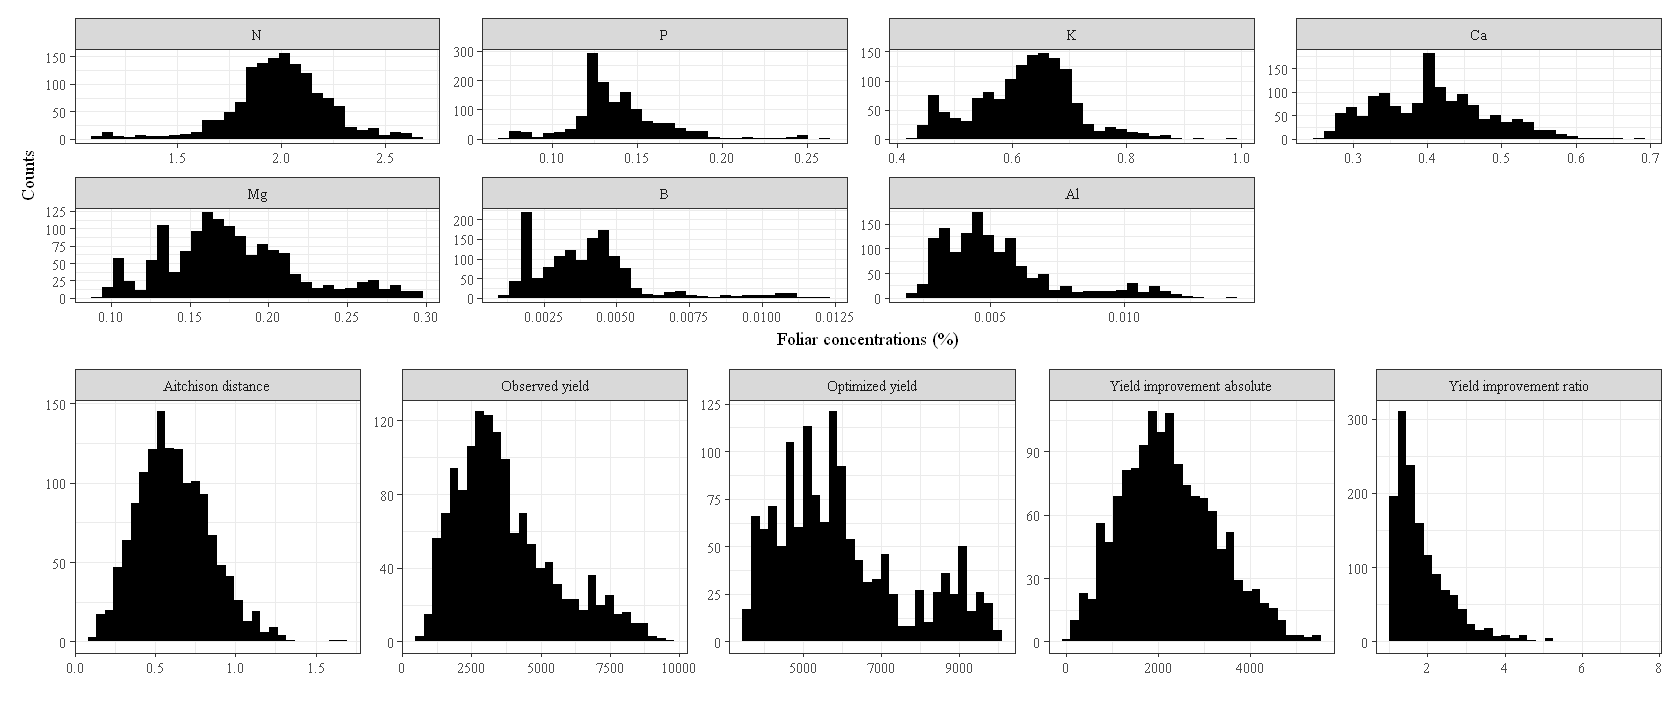

In [127]:
opt_comp <- ilrInv(opt_bal, V = gsi.buildilrBase(t(sbp_leaf))) %>% 
  data.frame() %>% 
  mutate(id = 1:nrow(opt_bal)) %>% 
  pivot_longer(cols = -c(id),
               names_to = "variable", values_to = "value") %>% 
  mutate(value = value * 100,
         variable = factor(variable, levels = c("N", "P", "K", "Ca", "Mg", "B", "Al", "Fv")))

opt_output <- tibble(id = 1:nrow(opt_bal),
                     `Observed yield` = opt_yield[, 1],
                     `Optimized yield` = opt_yield[, 2],
                     `Aitchison distance` = ait_dist) %>% 
  mutate(`Yield improvement ratio` = `Optimized yield` / `Observed yield`,
         `Yield improvement absolute` = `Optimized yield` - `Observed yield`,) %>%
  pivot_longer(cols = -c(id),
               names_to = "variable", values_to = "value")

opt_comp_gg <- opt_comp %>% 
  filter(variable != "Fv") %>% 
  ggplot(aes(x = value)) +
  facet_wrap(~variable, nrow = 2, scales = "free") +
  geom_histogram(bins = 30, fill = "black") +
  labs(x = "Foliar concentrations (%)", y = "Counts") +
  theme_bw() +
  theme(text = element_text(family = "serif"))

opt_out_gg <- opt_output %>% 
  ggplot(aes(x = value)) +
  facet_wrap(~variable, nrow = 1, scales = "free") +
  geom_histogram(bins = 30, fill = "black") +
  labs(x = "", y = "") +
  theme_bw() +
  theme(text = element_text(family = "serif"))

opt_comp_gg / opt_out_gg
ggsave("images/opt-distr.png", height = 10, width = 10, dpi = 300)

opt_comp %>% 
  group_by(variable) %>% 
  summarise(min = min(value),
            q25 = quantile(value, prob = 0.25),
            median = median(value),
            q75 = quantile(value, prob = 0.75),
            max = max(value))

The proportion of Aitchison distances shorter than 0.59.

In [128]:
quantInv <- function(distr, value) ecdf(distr)(value) # thanks https://stackoverflow.com/questions/9123800/how-do-i-calculate-the-probability-for-a-given-quantile-in-r
opt_output %>%
  filter(variable == "Aitchison distance") %>%
  pull(value) %>%
  quantInv(., 0.59)

[1] 0.4862717

The proportion of yields inferior to 5000.

In [129]:
opt_output %>%
  filter(variable == "Optimized yield") %>%
  pull(value) %>%
  quantInv(., 5000)

[1] 0.3099711

## Compare optimal distributions to the literature

In [130]:
nutrients_litt_source <- read_csv("data/literature-standards.csv")
nutrients_litt <- nutrients_litt_source %>%
  pivot_longer(cols = -c(Author, MinMax)) %>%
  pivot_wider(names_from = MinMax, values_from = value)

Parsed with column specification:
cols(
  Author = col_character(),
  MinMax = col_character(),
  N = col_double(),
  P = col_double(),
  K = col_double(),
  Ca = col_double(),
  Mg = col_double(),
  B = col_double(),
  Cu = col_double(),
  Zn = col_double(),
  Mn = col_double(),
  Fe = col_double(),
  Al = col_double()
)



### N

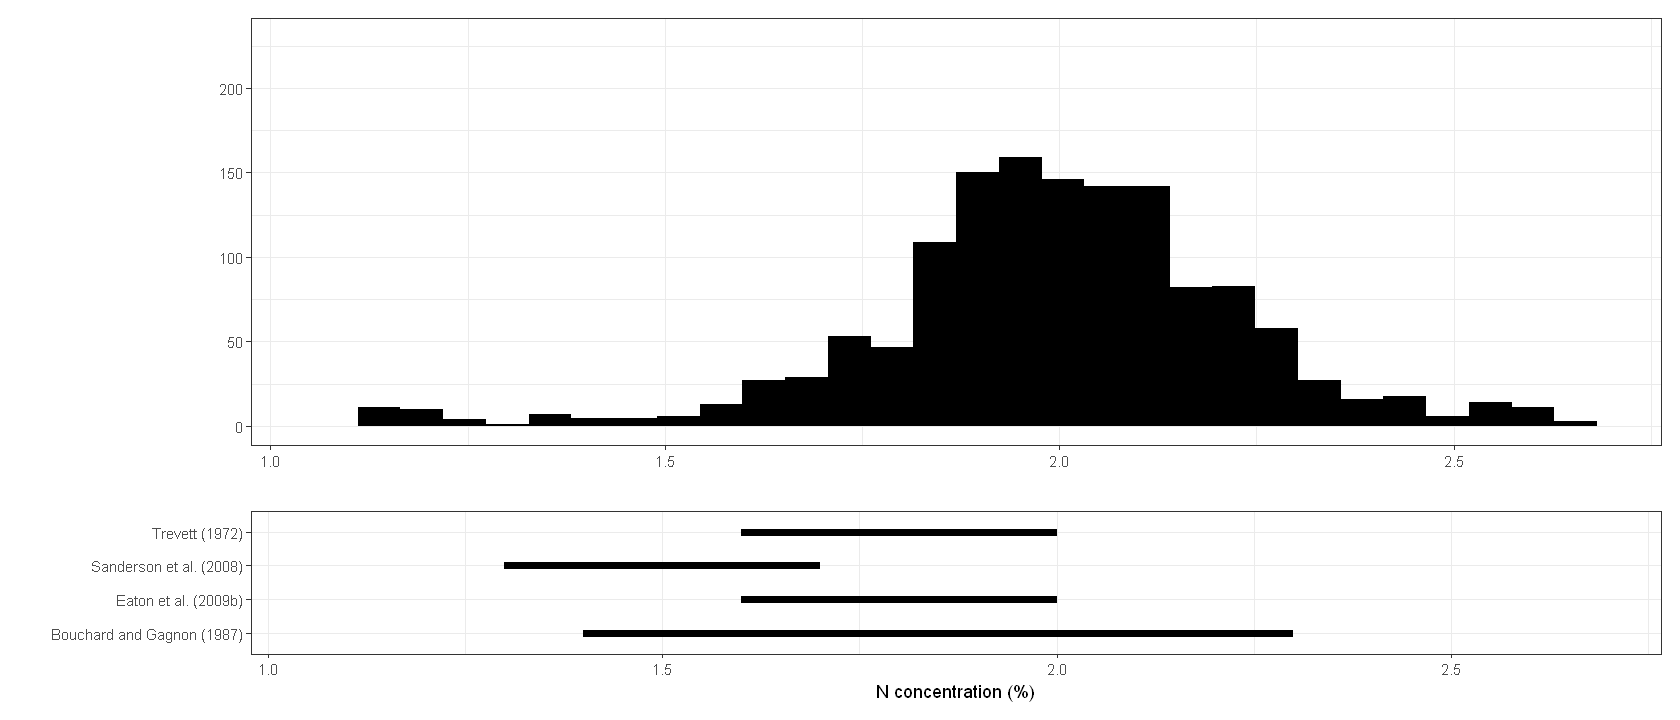

In [98]:
gg_nlitt <- nutrients_litt %>%
  filter(name == "N") %>%
  ggplot(aes(x = Minimum, y = Author)) +
  geom_segment(aes(xend = Maximum, yend = Author), lwd = 2) +
  #scale_x_continuous(limits = c(0, 14), breaks = seq(from = 0, to = 15, by = 2)) +
  #geom_vline(xintercept = 0, linetype = 2) +
  labs(x = "N concentration (%)", y = "") +
  expand_limits(x = c(1.06, 2.685)) +
  theme_bw()

gg_ndistr <- opt_comp %>% 
  filter(variable == "N") %>% 
  ggplot(aes(x = value)) +
  geom_histogram(fill = "black", bins = 30) +
  labs(x = "", y = "") +
  expand_limits(x = c(1.08, 2.6), y = c(0, 230)) +
  theme_bw()

gg_n <- gg_ndistr / gg_nlitt + plot_layout(heights = c(3, 1))
gg_n
ggsave("images/distr_n.png", height = 4, width = 6, dpi = 300)

### P

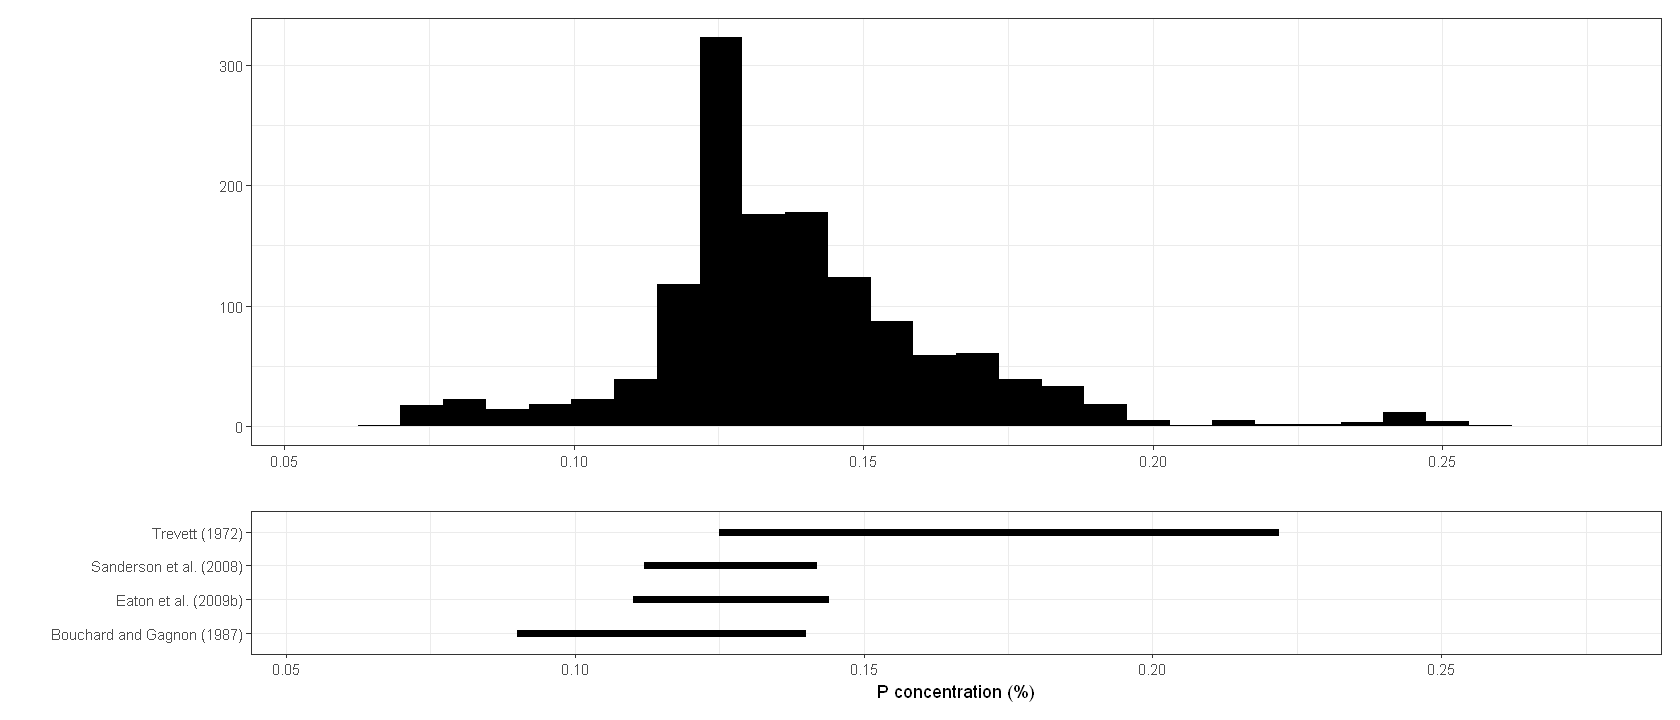

In [99]:
gg_plitt <- nutrients_litt %>%
  filter(name == "P") %>%
  ggplot(aes(x = Minimum, y = Author)) +
  geom_segment(aes(xend = Maximum, yend = Author), lwd = 2) +
  labs(x = "P concentration (%)", y = "") +
  expand_limits(x = c(0.055, 0.277)) +
  theme_bw()

gg_pdistr <- opt_comp %>% 
  filter(variable == "P") %>% 
  ggplot(aes(x = value)) +
  geom_histogram(fill = "black", bins = 30) +
  labs(x = "", y = "") +
  expand_limits(x = c(0.06, 0.274), y = c(0, 230)) +
  theme_bw()

gg_p <- gg_pdistr / gg_plitt + plot_layout(heights = c(3, 1))
gg_p
ggsave("images/distr_p.png", height = 4, width = 6, dpi = 300)

# K

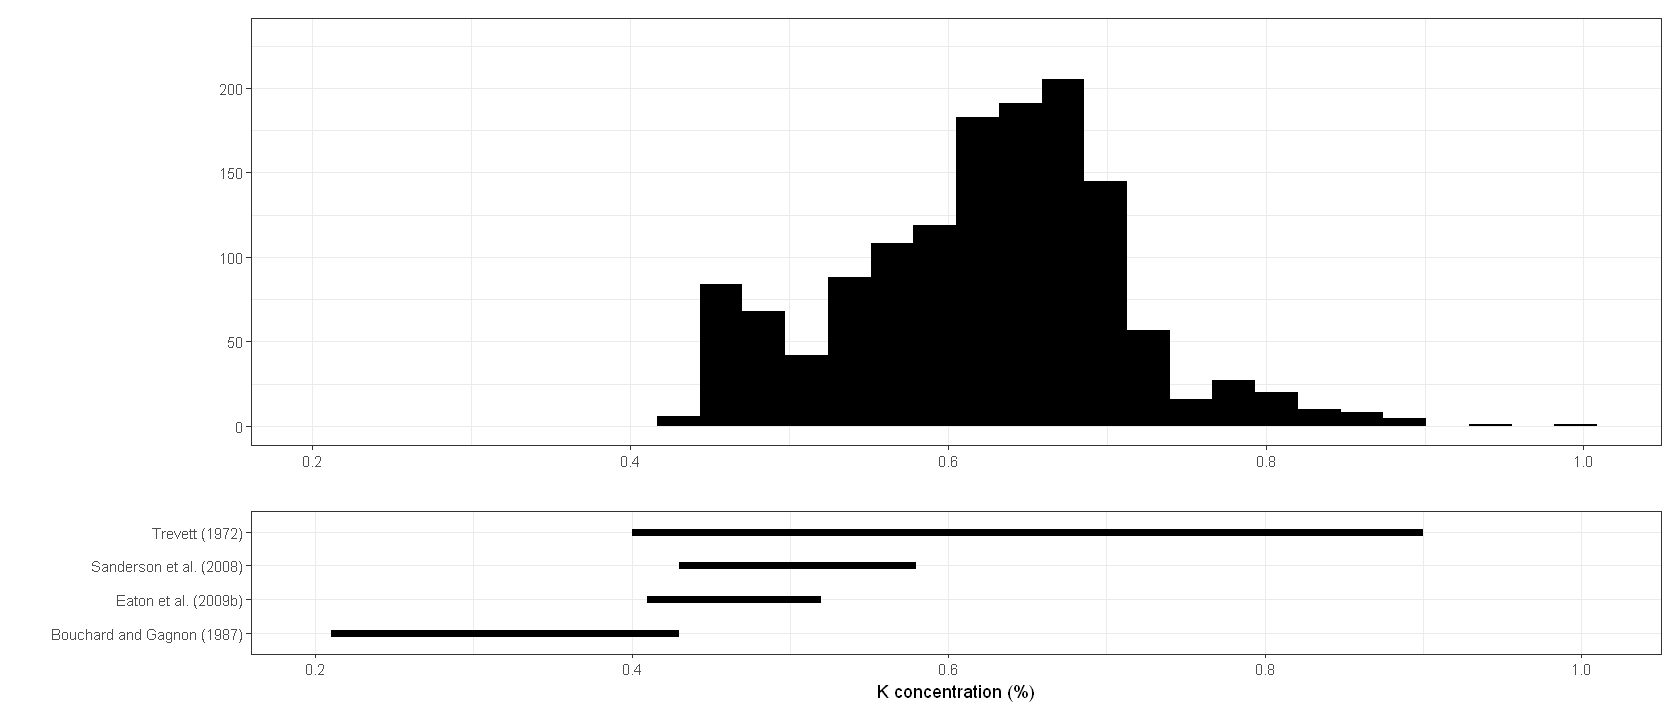

In [100]:
gg_klitt <- nutrients_litt %>%
  filter(name == "K") %>%
  ggplot(aes(x = Minimum, y = Author)) +
  geom_segment(aes(xend = Maximum, yend = Author), lwd = 2) +
  labs(x = "K concentration (%)", y = "") +
  expand_limits(x = c(0.2, 1.01)) +
  theme_bw()

gg_kdistr <- opt_comp %>% 
  filter(variable == "K") %>% 
  ggplot(aes(x = value)) +
  geom_histogram(fill = "black", bins = 30) +
  labs(x = "", y = "") +
  expand_limits(x = c(0.22, 1.0), y = c(0, 230)) +
  theme_bw()

gg_k <- gg_kdistr / gg_klitt + plot_layout(heights = c(3, 1))
gg_k
ggsave("images/distr_k.png", height = 4, width = 6, dpi = 300)

# Ca

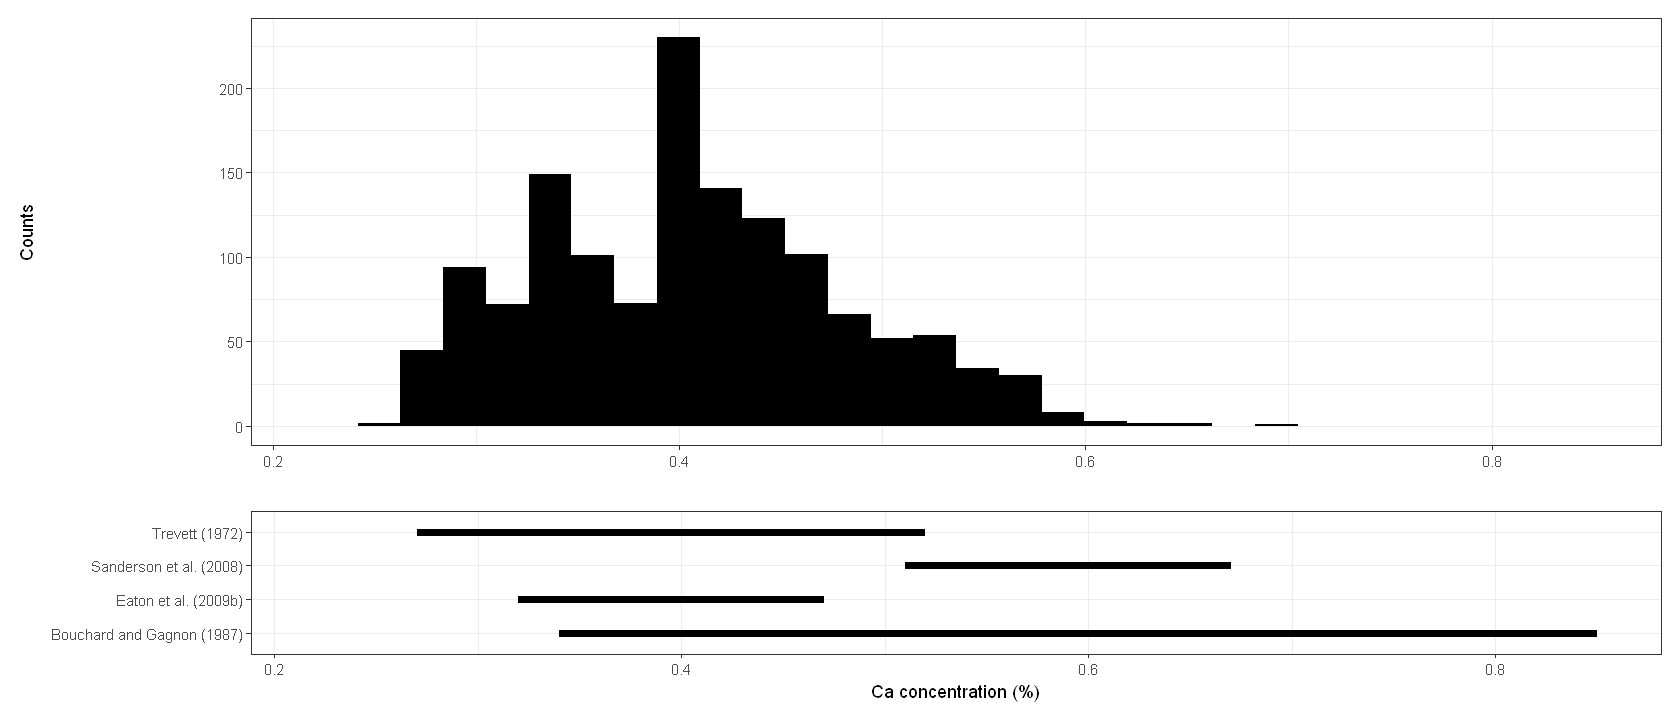

In [101]:
gg_calitt <- nutrients_litt %>%
  filter(name == "Ca") %>%
  ggplot(aes(x = Minimum, y = Author)) +
  geom_segment(aes(xend = Maximum, yend = Author), lwd = 2) +
  labs(x = "Ca concentration (%)", y = "") +
  expand_limits(x = c(0.22, 0.8)) +
  theme_bw()

gg_cadistr <- opt_comp %>% 
  filter(variable == "Ca") %>% 
  ggplot(aes(x = value)) +
  geom_histogram(fill = "black", bins = 30) +
  labs(x = "", y = "Counts") +
  expand_limits(x = c(0.23, 0.84), y = c(0, 230)) +
  theme_bw()

gg_ca <- gg_cadistr / gg_calitt + plot_layout(heights = c(3, 1))
gg_ca
ggsave("images/distr_ca.png", height = 4, width = 6, dpi = 300)

# Mg

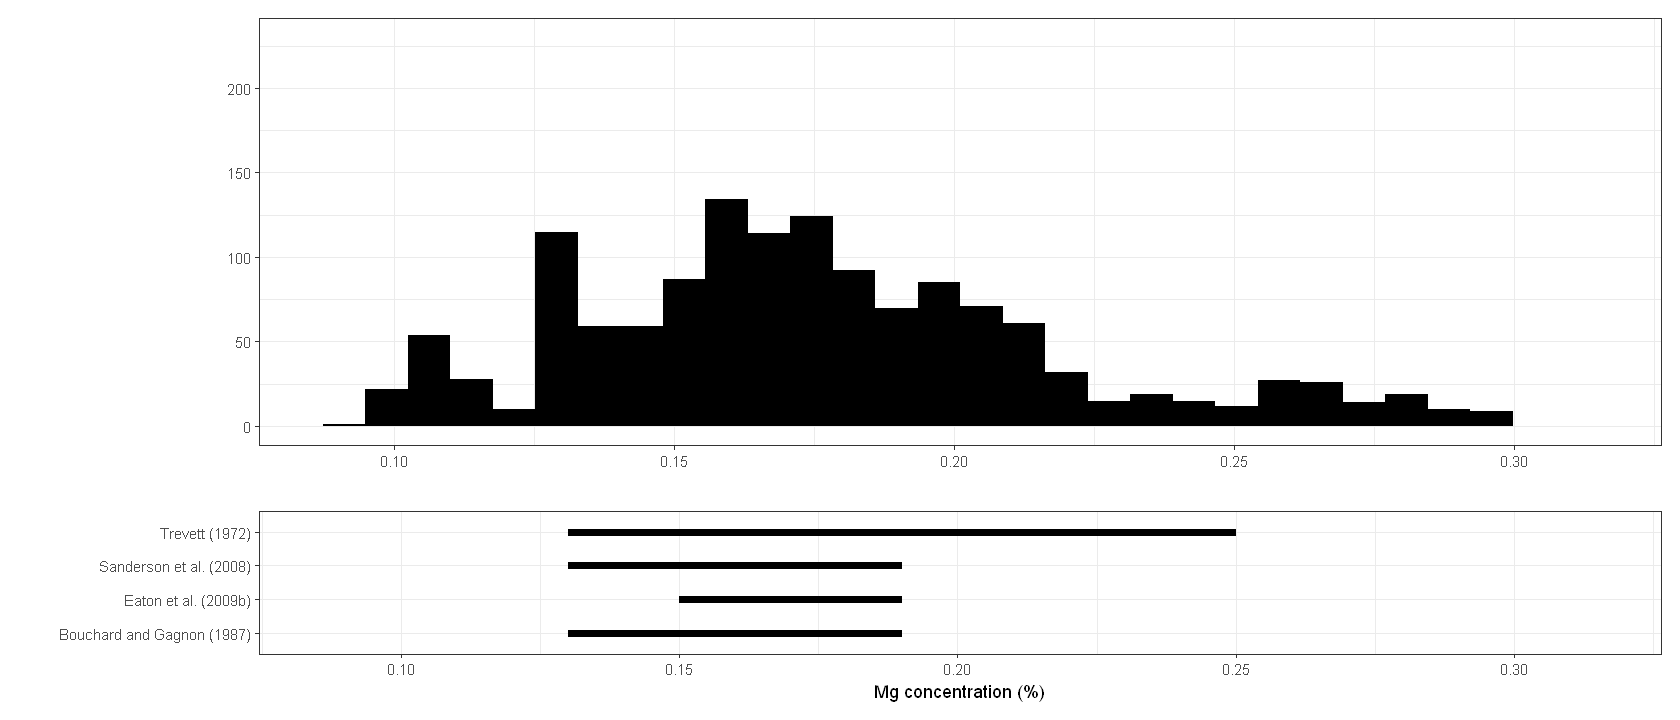

In [102]:
gg_mglitt <- nutrients_litt %>%
  filter(name == "Mg") %>%
  ggplot(aes(x = Minimum, y = Author)) +
  geom_segment(aes(xend = Maximum, yend = Author), lwd = 2) +
  labs(x = "Mg concentration (%)", y = "") +
  expand_limits(x = c(0.086, 0.315)) +
  theme_bw()

gg_mgdistr <- opt_comp %>% 
  filter(variable == "Mg") %>% 
  ggplot(aes(x = value)) +
  geom_histogram(fill = "black", bins = 30) +
  labs(x = "", y = "") +
  expand_limits(x = c(0.09, 0.31), y = c(0, 230)) +
  theme_bw()

gg_mg <- gg_mgdistr / gg_mglitt + plot_layout(heights = c(3, 1))
gg_mg
ggsave("images/distr_mg.png", height = 4, width = 6, dpi = 300)

# B

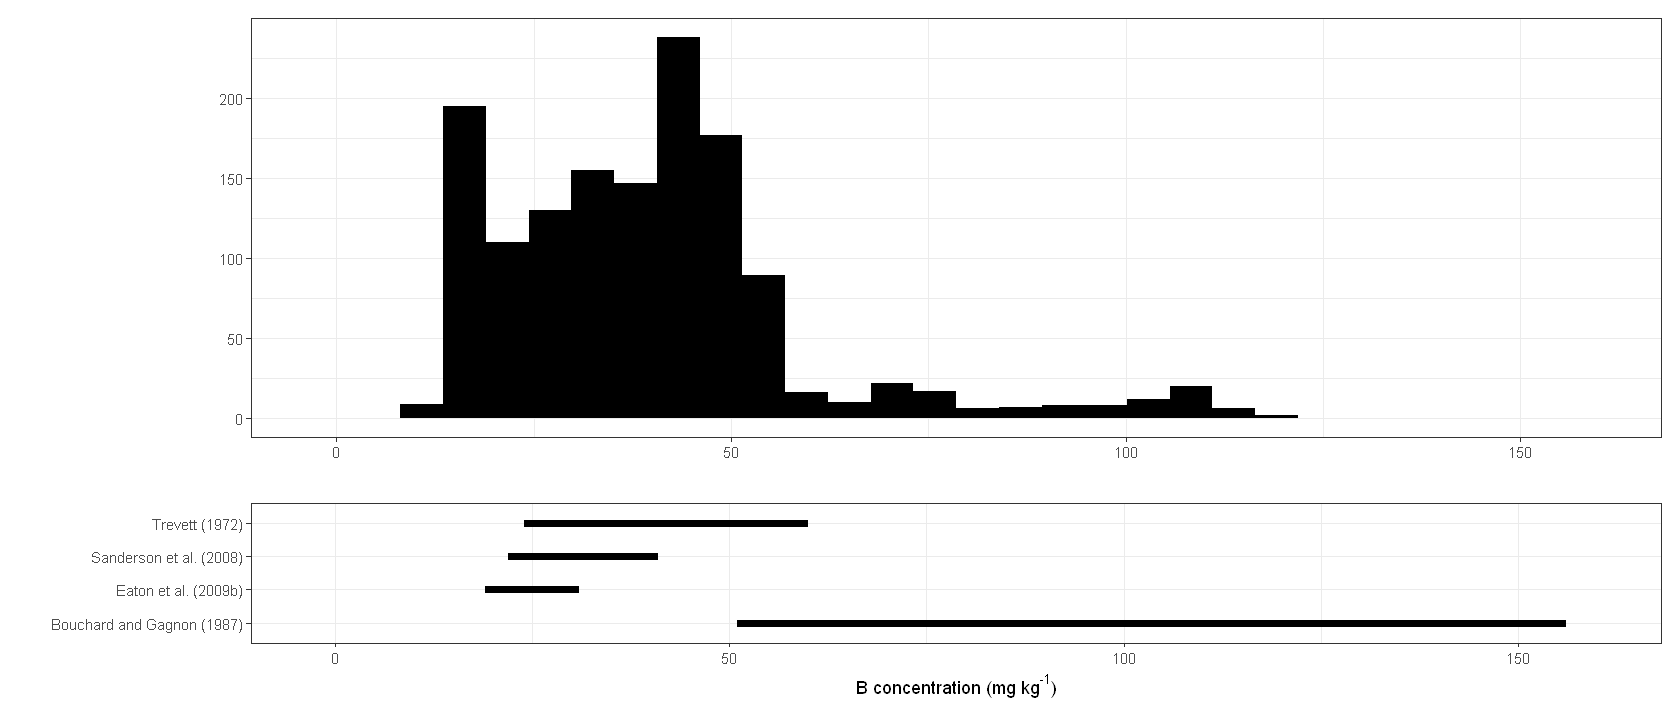

In [103]:
gg_blitt <- nutrients_litt %>%
  filter(name == "B") %>%
  ggplot(aes(x = Minimum, y = Author)) +
  geom_segment(aes(xend = Maximum, yend = Author), lwd = 2) +
  labs(x = expression("B concentration (mg kg"^"-1"*")"), y = "") +
  expand_limits(x = c(-2.5, 160)) +
  theme_bw()

gg_bdistr <- opt_comp %>% 
  filter(variable == "B") %>% 
  ggplot(aes(x = value * 10000)) +
  geom_histogram(fill = "black", bins = 30) +
  labs(x = "", y = "") +
  expand_limits(x = c(2, 159), y = c(0, 230)) +
  theme_bw()

gg_b <- gg_bdistr / gg_blitt + plot_layout(heights = c(3, 1))
gg_b
ggsave("images/distr_b.png", height = 4, width = 6, dpi = 300)

# Al

Warning message:
"Removed 3 rows containing missing values (geom_segment)."
Warning message:
"Removed 3 rows containing missing values (geom_segment)."


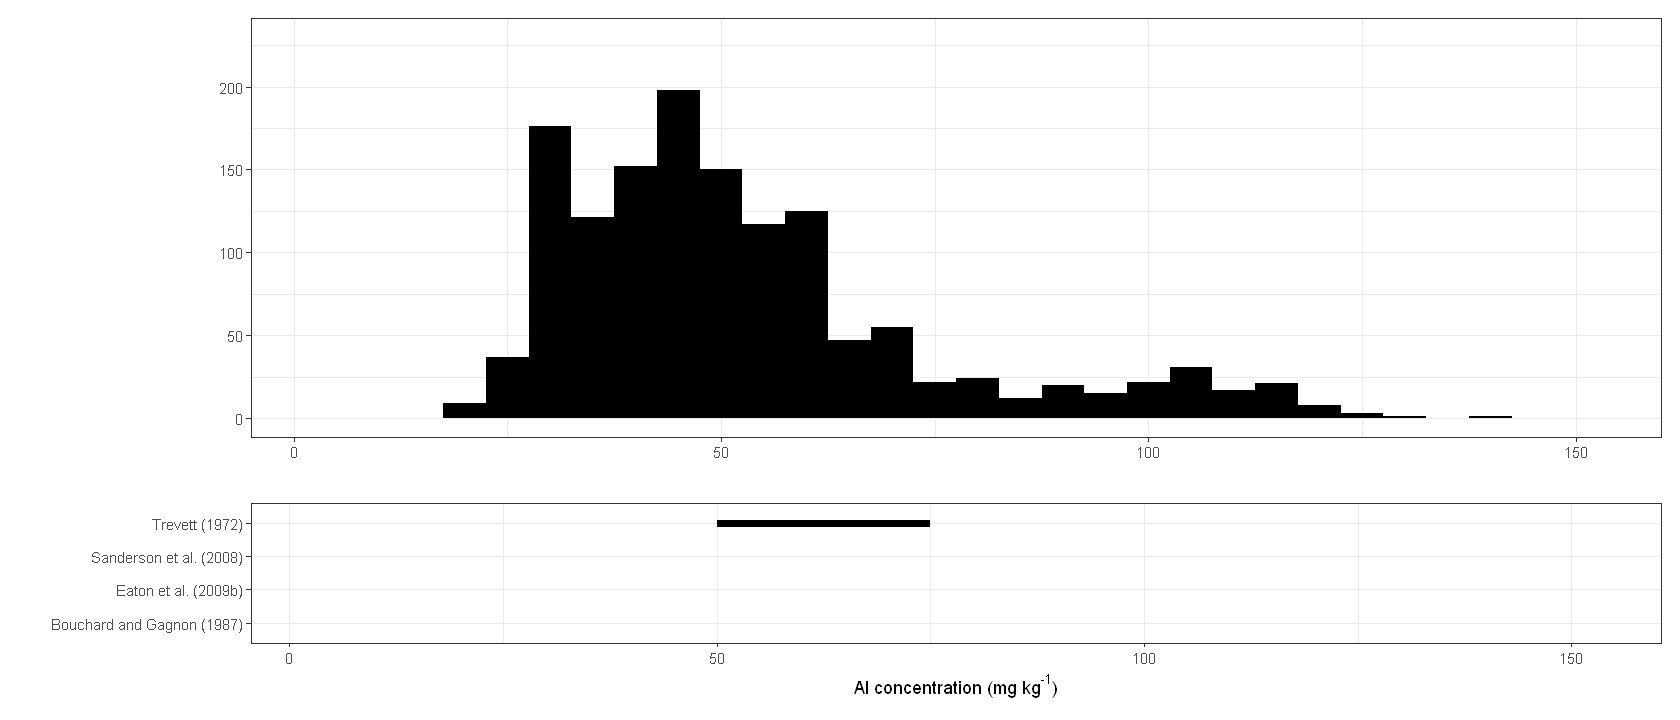

In [113]:
gg_allitt <- nutrients_litt %>%
  filter(name == "Al") %>%
  ggplot(aes(x = Minimum, y = Author)) +
  geom_segment(aes(xend = Maximum, yend = Author), lwd = 2) +
  labs(x = expression("Al concentration (mg kg"^"-1"*")"), y = "") +
  expand_limits(x = c(3, 153)) +
  theme_bw()

gg_aldistr <- opt_comp %>% 
  filter(variable == "Al") %>% 
  ggplot(aes(x = value * 10000)) +
  geom_histogram(fill = "black", bins = 30) +
  labs(x = "", y = "") +
  expand_limits(x = c(5, 150), y = c(0, 230)) +
  theme_bw()

gg_al <- gg_aldistr / gg_allitt + plot_layout(heights = c(3, 1))
gg_al
ggsave("images/distr_al.png", height = 4, width = 6, dpi = 300)

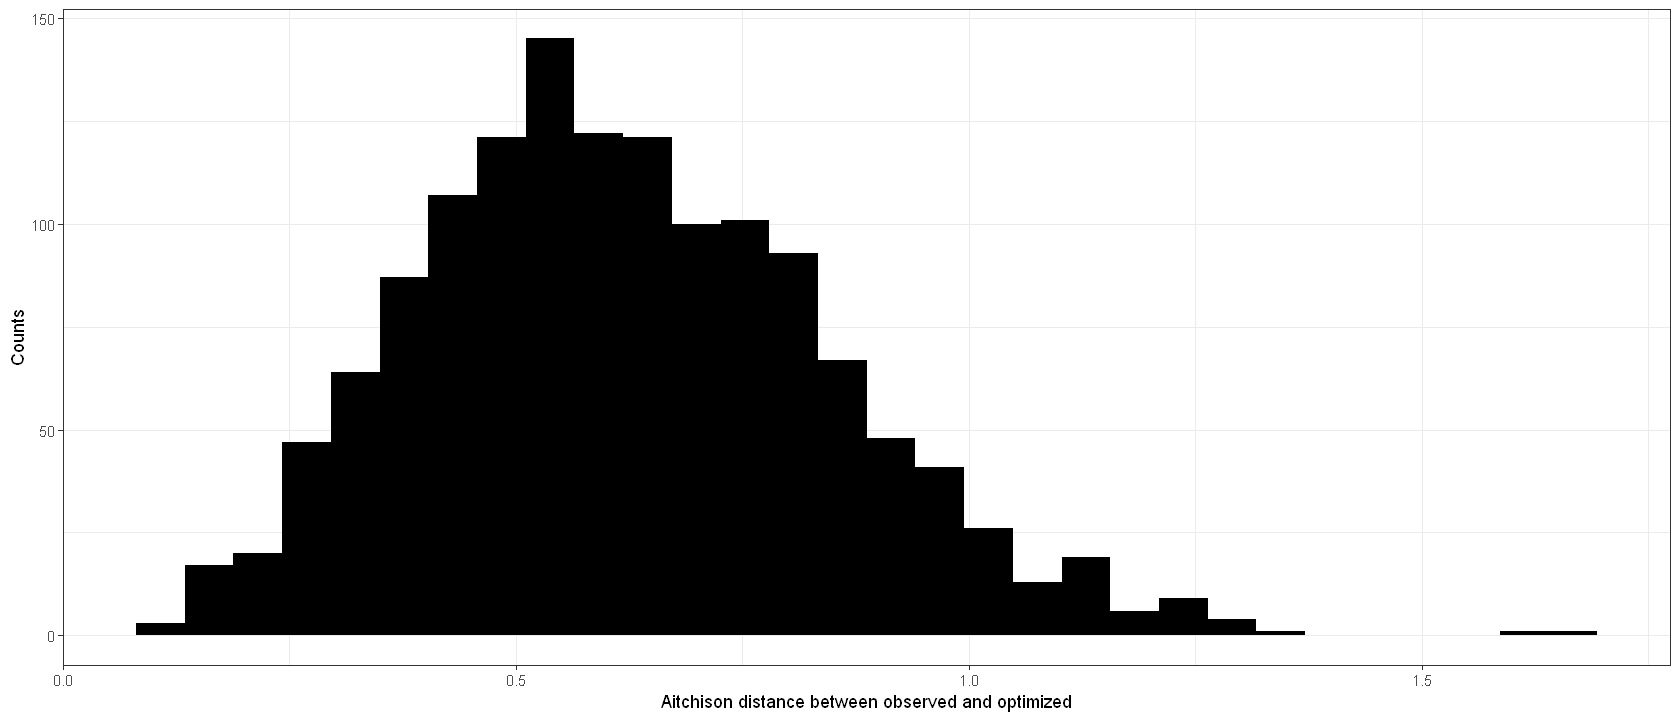

In [114]:
opt_output %>%
  filter(variable == "Aitchison distance") %>%
  ggplot(aes(x = value)) +
  geom_histogram(fill = "black", bins = 30) +
  labs(x = "Aitchison distance between observed and optimized", y = "Counts") +
  theme_bw() +
  ggsave("images/distr_aitdist.png", height = 3, width = 4, dpi = 300)

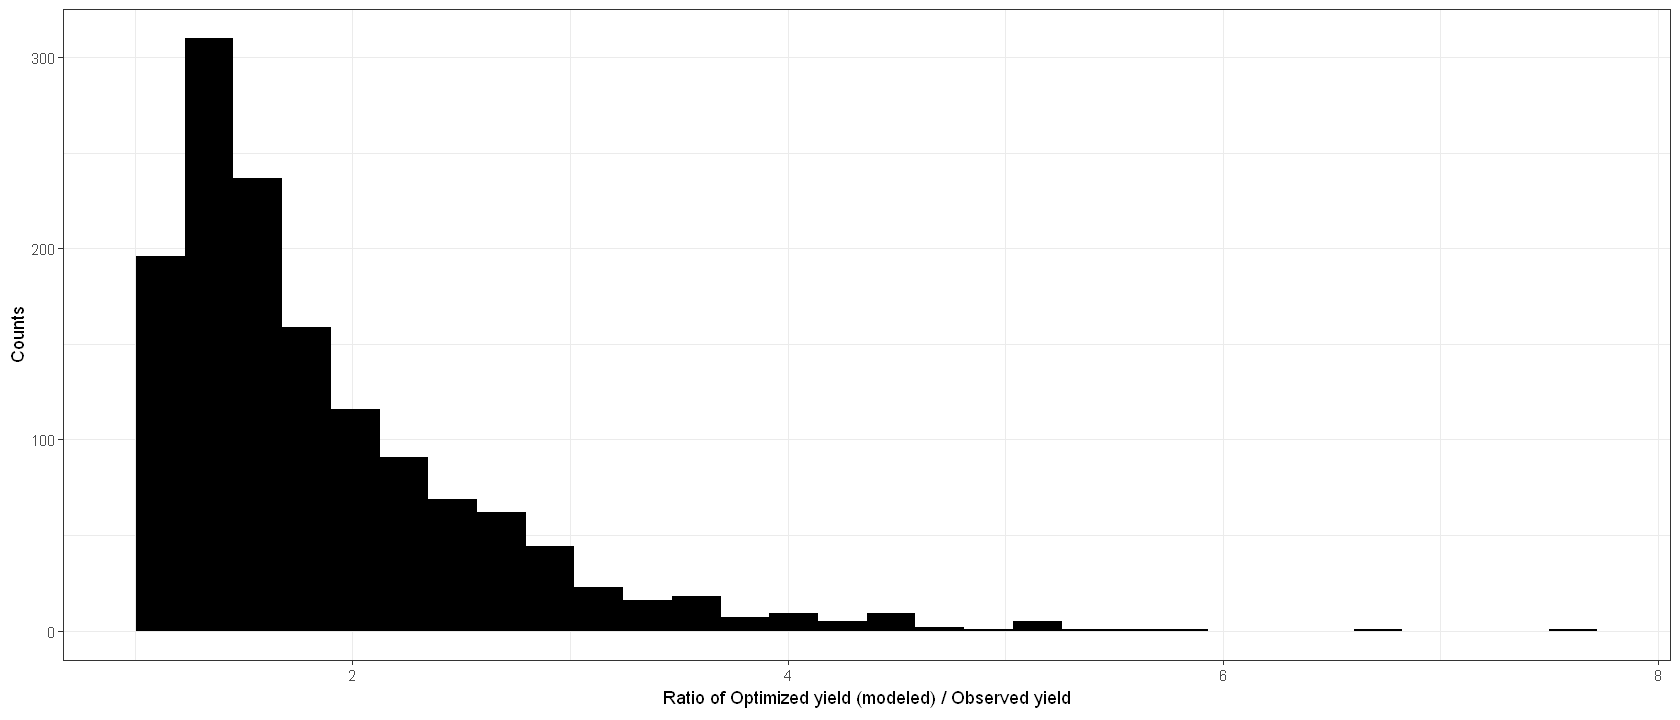

In [131]:
opt_output %>%
  filter(variable == "Yield improvement ratio") %>%
  ggplot(aes(x = value)) +
  geom_histogram(fill = "black", bins = 30) +
  #labs(x = expression("Yield improvement by optimizing the ionome (kg ha"^"-1"*")"), y = "Counts") +
  labs(x = expression("Ratio of Optimized yield (modeled) / Observed yield"), y = "Counts") +
  theme_bw() +
  ggsave("images/distr_yield.png", height = 3, width = 4, dpi = 300)

In [132]:
opt_output %>%
  filter(variable %in% c("Aitchison distance", "Yield improvement ratio", "Yield improvement absolute")) %>%
  group_by(variable) %>%
  summarise(median = median(value))

variable,median
<chr>,<dbl>
Aitchison distance,0.5974682
Yield improvement absolute,2164.7727727
Yield improvement ratio,1.6183858


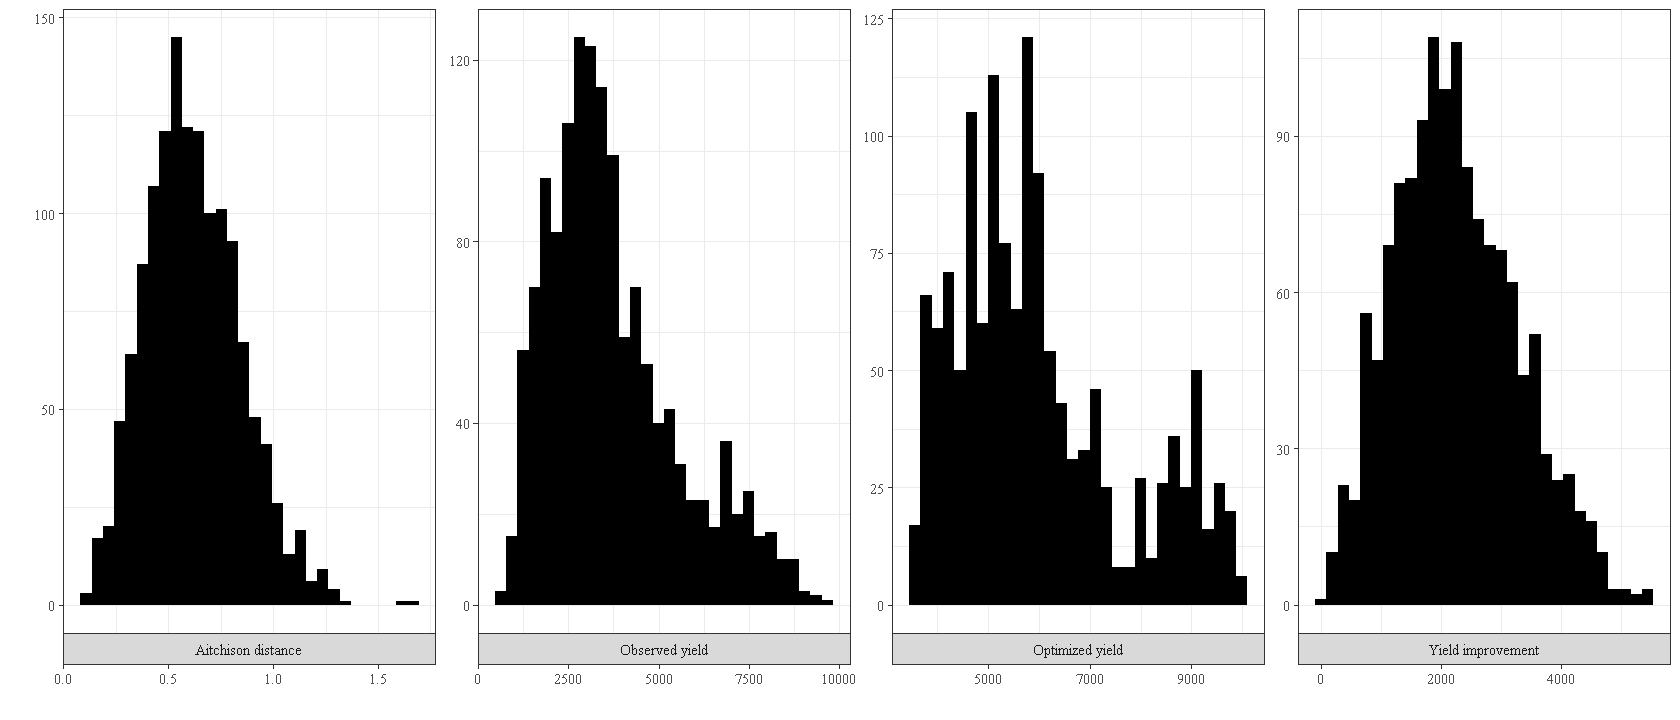

In [108]:
opt_output %>% 
  ggplot(aes(x = value)) +
  facet_wrap(~variable, nrow = 1, scales = "free", strip.position="bottom") +
  geom_histogram(bins = 30, fill = "black") +
  labs(x = "", y = "") +
  theme_bw() +
  theme(text = element_text(family = "serif"))